# Table of Contents
 <p><div class="lev1"><a href="#Simulate-locations"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate locations</a></div><div class="lev1"><a href="#Simulate-data-from-GP"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate data from GP</a></div><div class="lev1"><a href="#Inference"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></div><div class="lev1"><a href="#Estimate-mean-treatment-effect"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimate mean treatment effect</a></div><div class="lev2"><a href="#Distance-averaged-treatment-effect"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distance-averaged treatment effect</a></div><div class="lev2"><a href="#Inverse-variance-weighted-treatment-effect"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Inverse-variance weighted treatment effect</a></div><div class="lev2"><a href="#Simulate-under-the-null"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Simulate under the null</a></div><div class="lev2"><a href="#Simulate-under-alternative"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Simulate under alternative</a></div><div class="lev1"><a href="#Hypothesis-testing-(failed-idea)"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hypothesis testing (failed idea)</a></div><div class="lev1"><a href="#Hypothesis-test-using-$\chi^2$-test"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hypothesis test using <span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-112-Frame" style=""><nobr><span class="math" id="MathJax-Span-2176" role="math" style="width: 1.252em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.027em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.284em, 1000.002em, 2.502em, -999.998em); top: -2.21em; left: 0.002em;"><span class="mrow" id="MathJax-Span-2177"><span class="msubsup" id="MathJax-Span-2178"><span style="display: inline-block; position: relative; width: 0.995em; height: 0px;"><span style="position: absolute; clip: rect(3.463em, 1000.002em, 4.296em, -999.998em); top: -4.005em; left: 0.002em;"><span class="mi" id="MathJax-Span-2179" style="font-family: STIXMathJax_Main-italic;">χ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.034em;"></span></span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span><span style="position: absolute; top: -4.357em; left: 0.546em;"><span class="mn" id="MathJax-Span-2180" style="font-size: 70.7%; font-family: STIXMathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.213em;"></span></span></span><span style="border-left-width: 0.002em; border-left-style: solid; display: inline-block; overflow: hidden; width: 0px; height: 1.348em; vertical-align: -0.267em;"></span></span></nobr></span><script type="math/tex" id="MathJax-Element-112">\chi^2</script> test</a></div><div class="lev2"><a href="#p-values-under-the-null"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>p-values under the null</a></div><div class="lev2"><a href="#p-values-under-alternative"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>p-values under alternative</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\below}{\unicode{x25E7}}
    \newcommand{\above}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jbelow}{\unicode{x21E5}}
    \newcommand{\jabove}{\unicode{x21E4}}
$$

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Simulate locations

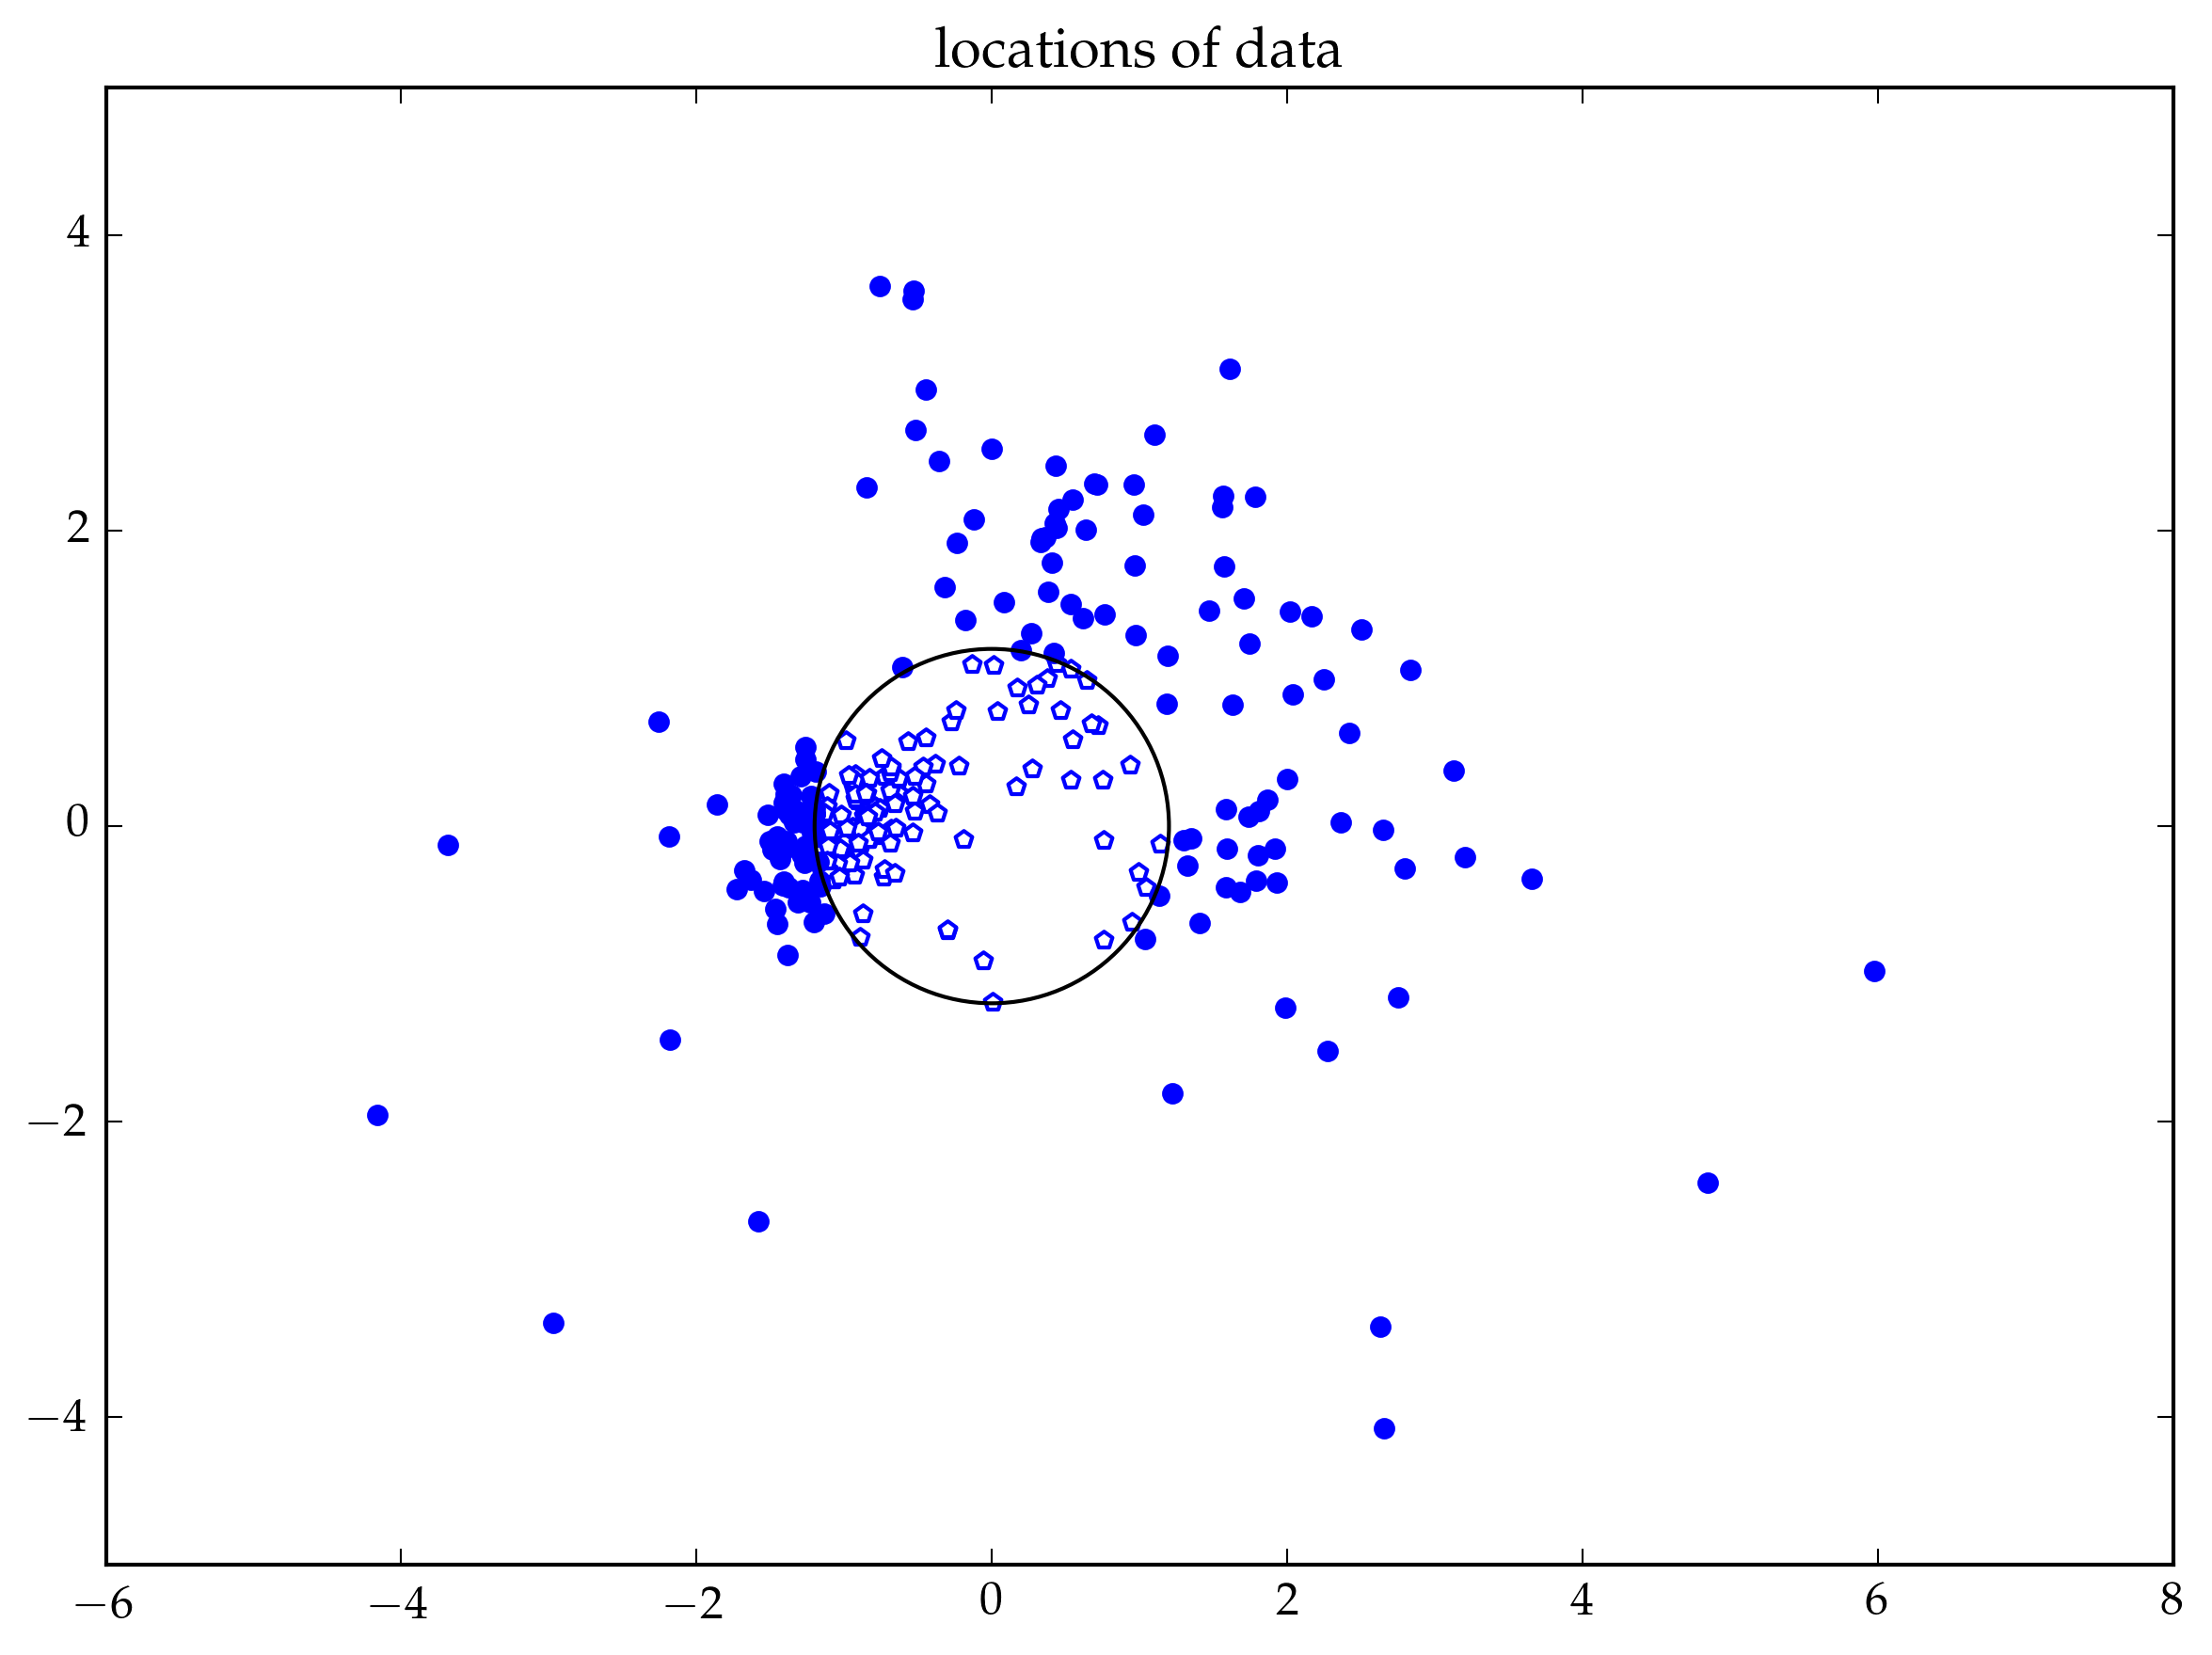

In [2]:
city = MultivariateNormal([-1.0,0.0], [[0.1,0.05] [0.05, 0.1]])
village = MultivariateNormal([1.0,1.0], [[1.0,-0.5] [-0.5, 1.0]])
countryside = MultivariateNormal([0.0, 0.0], [[4.0,0.0] [0.0, 4.0]])
X=[rand(city, 150) rand(village, 100) rand(countryside, 30)]
_,n = size(X)
r◫ = 1.2
inside = vec((X[1,:].^2 .+ X[2,:].^2) .< r◫^2)
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p")
plt.scatter(X[1,!inside],X[2,!inside], color="blue")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data");

# Simulate data from GP

In [3]:
Lstar=1.0
σf_star=2.0
σy2_star=0.5
kern = SE(log(Lstar), log(σf_star))

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


Type: GaussianProcesses.SEIso, Params: [0.0,0.6931471805599453]


In [4]:
Σprior=GaussianProcesses.crossKern(X, kern)
μprior=zeros(n)
Σobs=copy(Σprior)
for i in 1:n
    Σobs[i,i] += σy2_star
end
prior=MultivariateNormal(μprior,Σobs)
Y=rand(prior)
;

In [5]:
n◫ = 120
α◫ = linspace(0,2π,n◫)
x1◫ = cos(α◫)*r◫
x2◫ = sin(α◫)*r◫
X◫ = [x1◫ x2◫]'
size(X◫)

(2,120)

# Inference

In [6]:
gp_fit_inside = GP(X[:,inside], Y[inside], MeanZero(), kern, log(σy2_star))
gp_fit_outside = GP(X[:,!inside], Y[!inside], MeanZero(), kern, log(σy2_star))
;

In [7]:
pred_inside = predict(gp_fit_inside, X◫; full_cov=true)
pred_outside = predict(gp_fit_outside, X◫; full_cov=true)

([-1.42612,-1.34323,-1.24035,-1.11648,-0.971002,-0.803871,-0.615692,-0.40781,-0.182344,0.0578359  …  -1.4742,-1.52014,-1.55438,-1.57677,-1.58694,-1.58432,-1.56808,-1.53716,-1.4903,-1.42612],
120x120 Array{Float64,2}:
 0.131398   0.135332   0.138176   …  0.120615   0.126457   0.131398 
 0.135332   0.140703   0.144918      0.121605   0.128919   0.135332 
 0.138176   0.144918   0.150472      0.121739   0.130393   0.138176 
 0.139874   0.147889   0.154717      0.121015   0.13085    0.139874 
 0.140397   0.149558   0.157565      0.119451   0.130288   0.140397 
 0.139745   0.149901   0.158964   …  0.11708    0.128725   0.139745 
 0.137947   0.148926   0.158899      0.113956   0.126207   0.137947 
 0.135058   0.146675   0.157392      0.110146   0.122796   0.135058 
 0.131159   0.14322    0.154501      0.105729   0.118577   0.131159 
 0.126351   0.138661   0.15032       0.100796   0.113646   0.126351 
 0.120753   0.133122   0.144972   …  0.0954429  0.108114   0.120753 
 0.114498   0.126744   0

In [8]:
μposterior = pred_inside[1].-pred_outside[1]
Σposterior = pred_inside[2]+pred_outside[2]
;

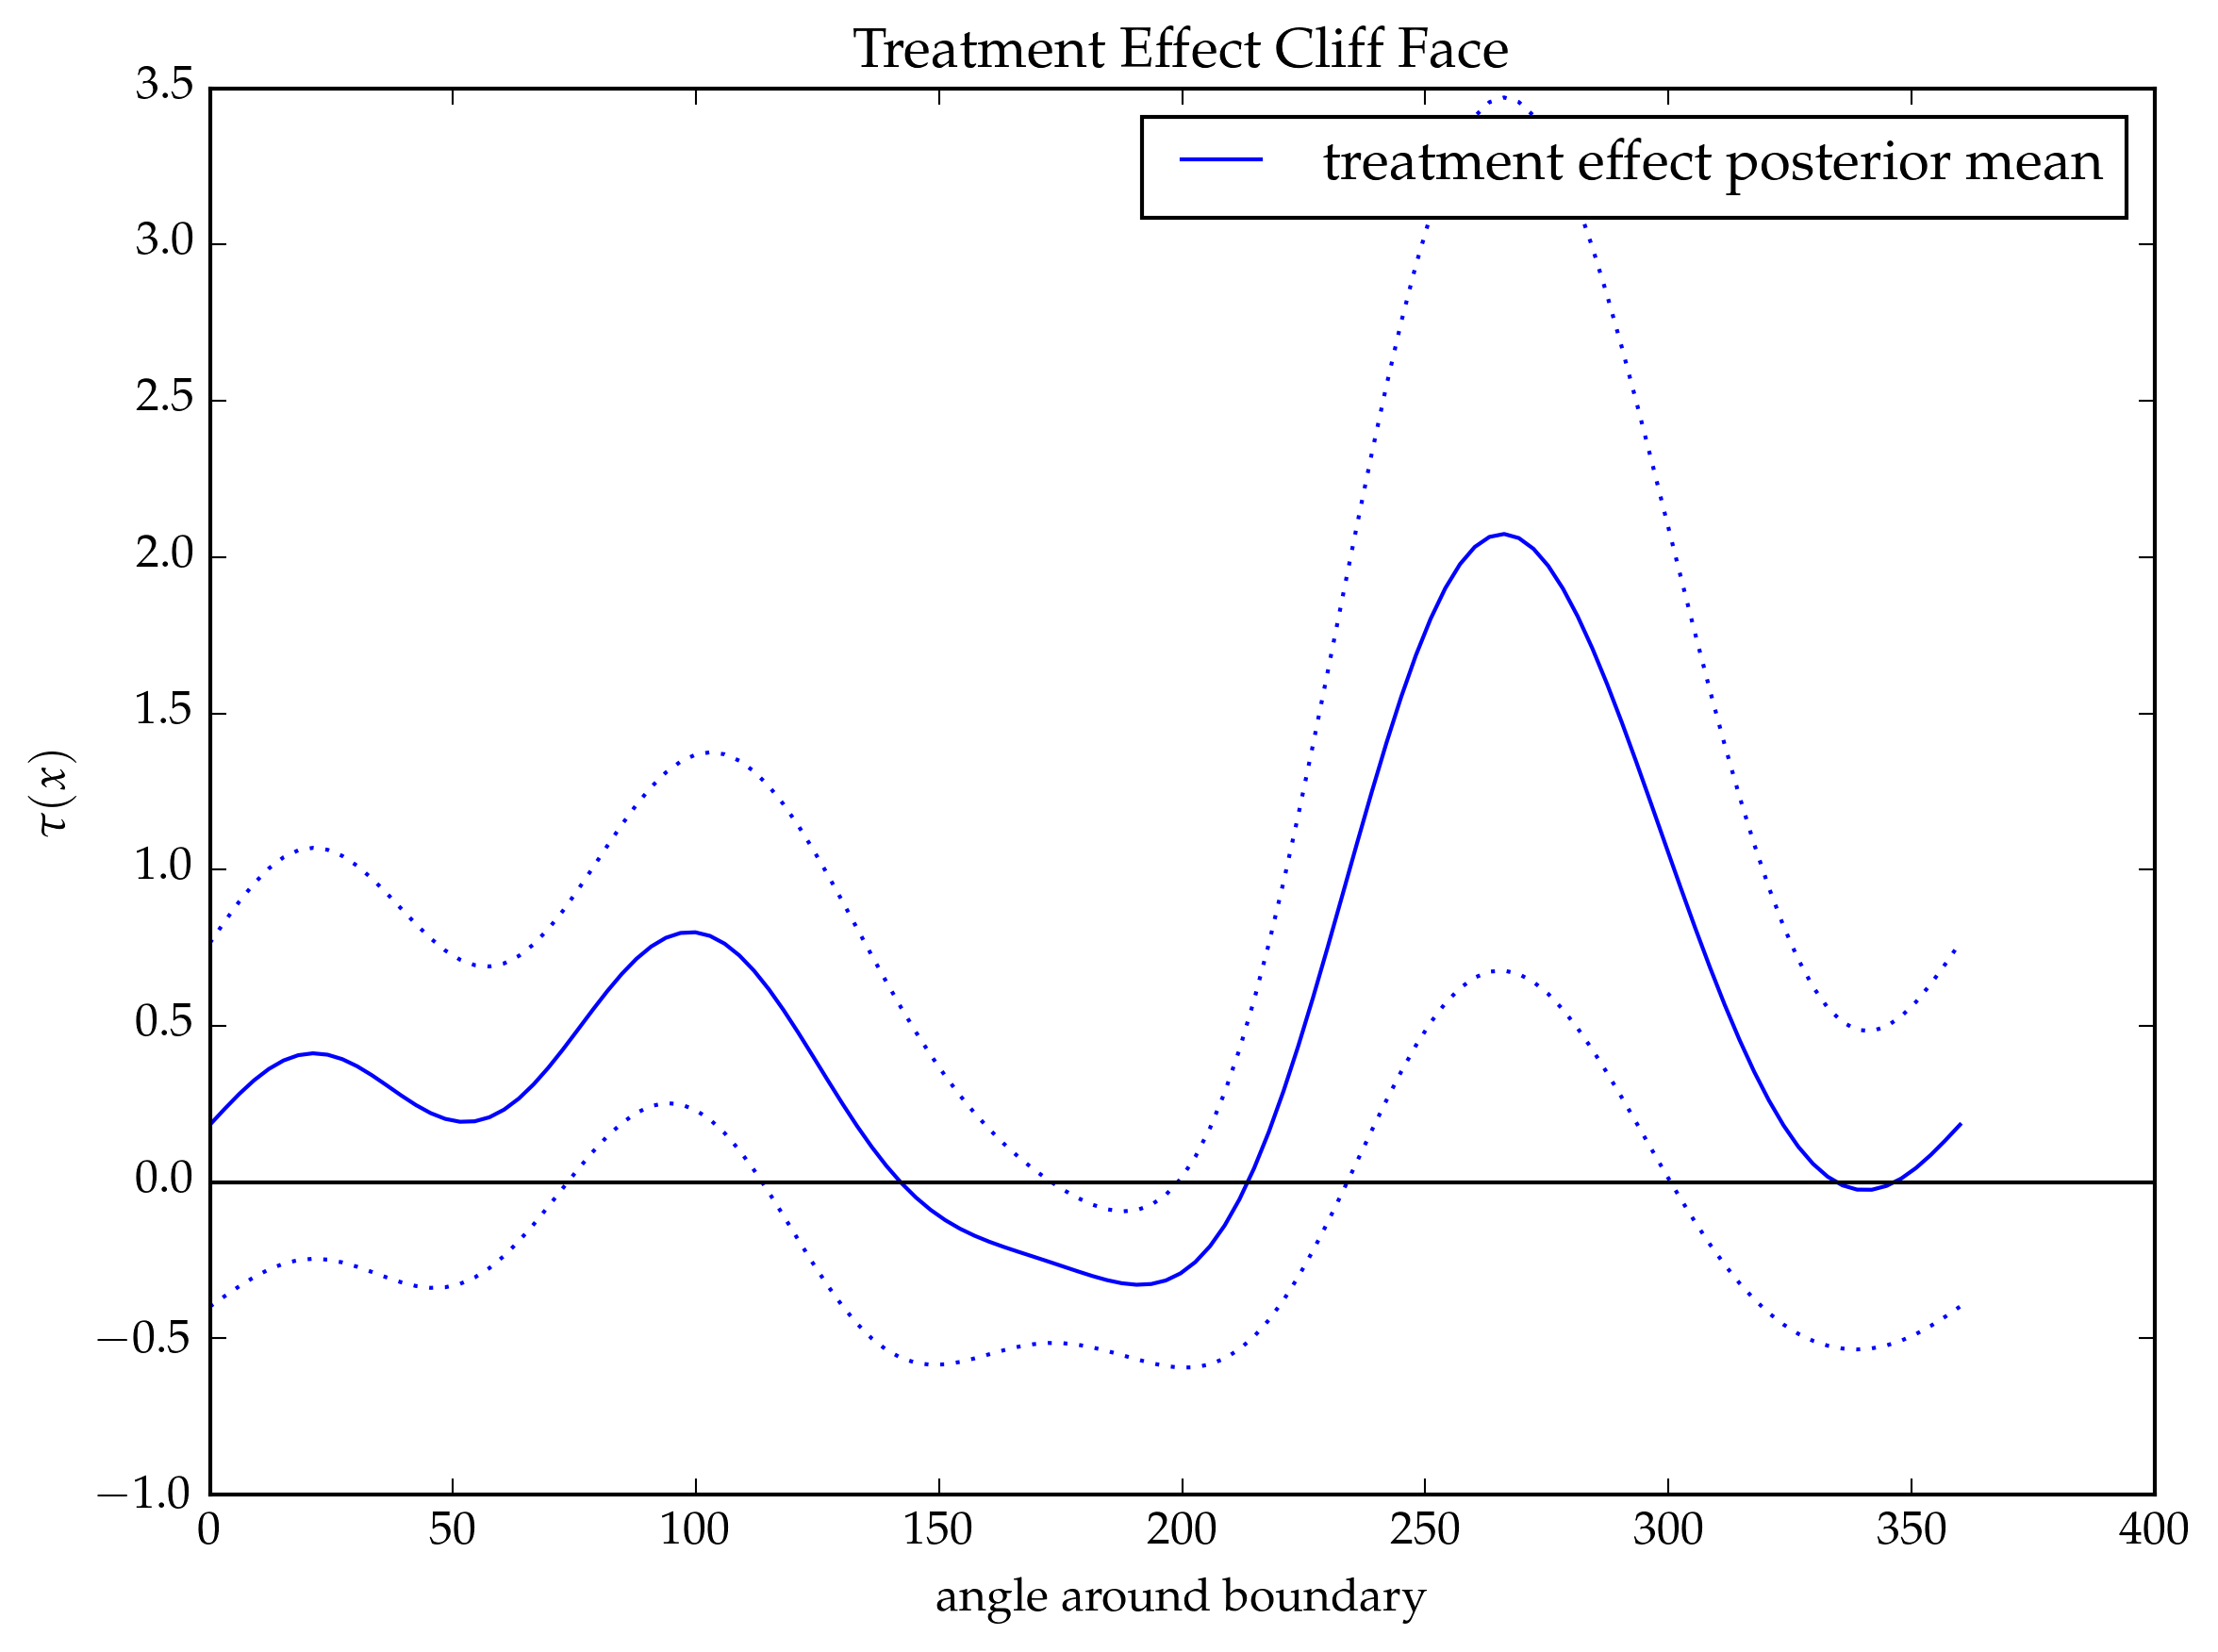

In [9]:
plt.plot(α◫*360/2π, μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(α◫*360/2π, μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(α◫*360/2π, μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black")
plt.title("Treatment Effect Cliff Face")
plt.ylabel(L"\tau(x)")
plt.xlabel("angle around boundary")
plt.legend()
;

# Estimate mean treatment effect

The output of the 2GP model is a posterior distribution of $\tau_\discont \mid Y,X$. Conveniently, because it is the difference of two GPs, the posterior of $\tau$ is itself a GP. Concretely, we evaluate it on a grid along the boundary, and so the posterior is normally distributed with mean $\mu^{post}$ and $\Sigma^{post}$. 

Let's think a little bit about estimands and estimators. Two possibilities occur to me:
## Distance-averaged treatment effect
The first idea is to just average the posterior treatment effect along the boundary. 
\begin{align}
    \tau &= \frac{\oint_\discont \left. \tau(x) dx \right.}{\oint_\discont \left. dx \right.} \\
    \hat{\tau} &= \frac{\oint_\discont \left. \tau(x \mid Y,X) dx \right.}{\oint_\discont \left. dx \right.} \\
    \E\hat{\tau} &\approx \frac{\sum_{j=1}^n \left. \mu^{post}_j \right.}{n} \\
        &= \ones_n^\intercal \mu^{post} / n\\
    \V\hat{\tau} &\approx \frac{\sum_{i=1}^n \sum_{j=1}^n \Sigma^{post}_{ij}}{n^2} \\
        &= \ones_n^\intercal  \Sigma^{post} \ones_n / n^2
\end{align}
This assumes the chosen grid along the boundary is evenly sampled. Otherwise, we need to account for the space occupied by each point. We would encode this with $\delta$, a vector of the lengths of the boundary occupied by each point in $X_\discont$, and we would get
\begin{align}
    \E\hat{\tau} &\approx \frac{\delta^\intercal \mu^{post}}{\delta^\intercal \ones_n} \\
    \V\hat{\tau} &\approx \frac{\delta^\intercal \Sigma^{post} \delta}{\delta^\intercal \delta}
\end{align}

In [34]:
τhat_unweighted = sum(μposterior)/n◫
Vτhat_unweighted = sum(Σposterior)/n◫^2
Normal(τhat_unweighted, √Vτhat_unweighted)

Distributions.Normal(μ=0.49641181435923787, σ=0.3545825900556553)

The problem with this is that the estimated variance $\V\hat{\tau}$ will blow up if there are sparsely populated segments of the boundary. It's the correct estimator for this estimand, but inference is essentially impossible if there are parts of the boundary where nobody lives (let's say the boundary goes through a big lake for example).

## Inverse-variance weighted treatment effect

This leads to the idea of downweighting the local treatment effects by their posterior variance. We are upweighting segments with high certainty, and downweighting high-variance segments of the boundary. My intuition is that instead of giving the same weight to each boundary length, we give the same length to each datapoint along the boundary (downweighted for units further away from the boundary). If we have twice as many people living in one area, the variance will be halved, and hence the weight doubled.

\begin{align}
    \E\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \mu^{post}}{\ones_n^T \Sigma^{-1} \ones_n} \\
    \V\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \ones_n}{\del{\ones_n^T \Sigma^{-1} \ones_n}^2} \\
    &= 1 \big/ \del{\ones_n^T \Sigma^{-1} \ones_n}
\end{align}

In [54]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=-0.11944932162809258, σ=0.18080250300197653)

## Simulate under the null

Sensibly, since we are simulating from a null hypothesis, 0 is included in a 1$\sigma$ credible interval. Let's see how often that will be the case. To save ourselves some trouble, we'll keep the positions of the data fixed, so we can just simulate a new $Y$, thus leaving the covariance matrix unchanged.

In [55]:
function update_alpha!(gp::GP)
    m = GaussianProcesses.meanf(gp.m,gp.x)
    gp.alpha = gp.cK \ (gp.y - m)
end
type SimOutput
    τhat::Float64
    Vτhat::Float64
end
effsize(so::SimOutput) = so.τhat/√(so.Vτhat)

function sim_null()
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    
    # simple average, unweighted
    τhat = sum(μpost)/n◫
    Vτhat = sum(Σpost)/n◫^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    denom = dot(ones(n◫),(Σpost \ ones(n◫)))
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end

eff_null = [sim_null() for _ in 1:10000];

It is a [mathematical fact](https://en.wikipedia.org/wiki/Inverse-variance_weighting) that the inverse-variance weighted average has the lowest possible variance of all weighted averages of a vector. Let's check this is true in all our simulations:

In [56]:
all(Bool[sim[1].Vτhat >= sim[1].Vτhat for sim in eff_null])

true

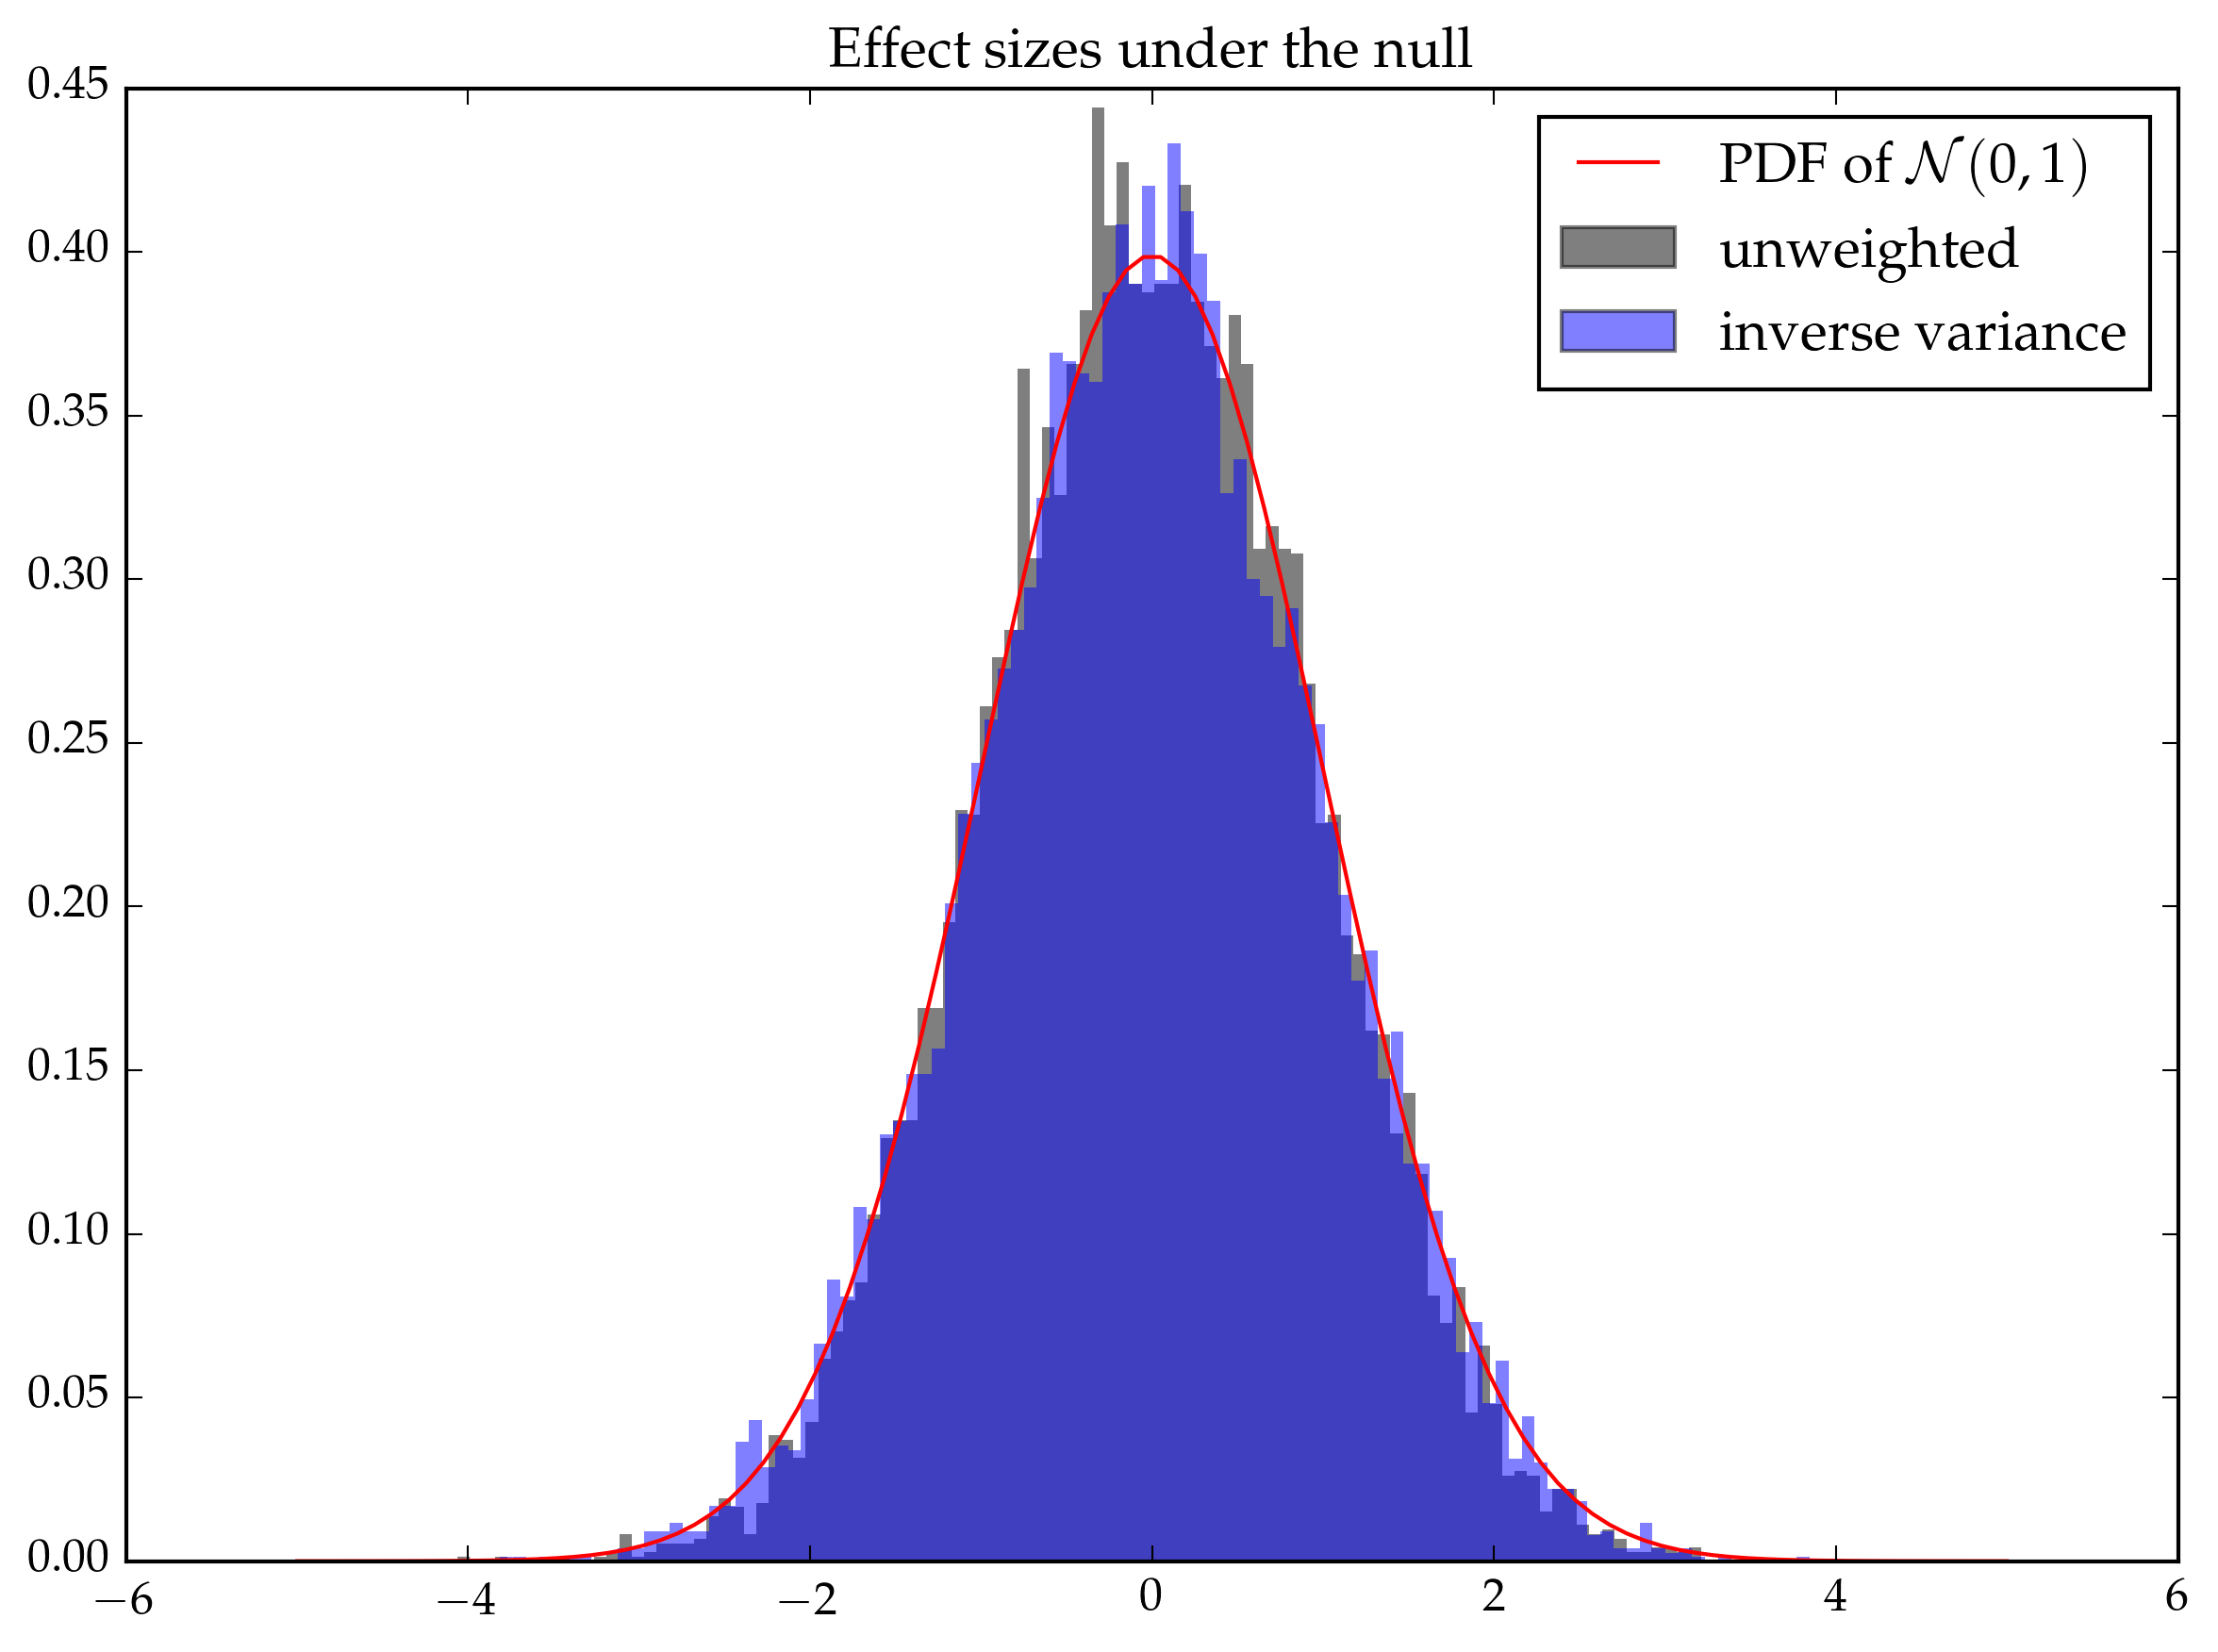

In [57]:
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_null], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_null], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title("Effect sizes under the null")
plt.legend()
;

Interesting! The standardized effect $\E\hat{\tau} \big/ \sqrt{\V\hat{\tau}}$ is roughly a standard normal for both estimators. Encouraging...

## Simulate under alternative

In [58]:
function sim_alt(τ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    
    # simple average, unweighted
    τhat = sum(μpost)/n◫
    Vτhat = sum(Σpost)/n◫^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    denom = dot(ones(n◫),(Σpost \ ones(n◫)))
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end
eff_alt = [sim_alt(0.5) for _ in 1:10000];

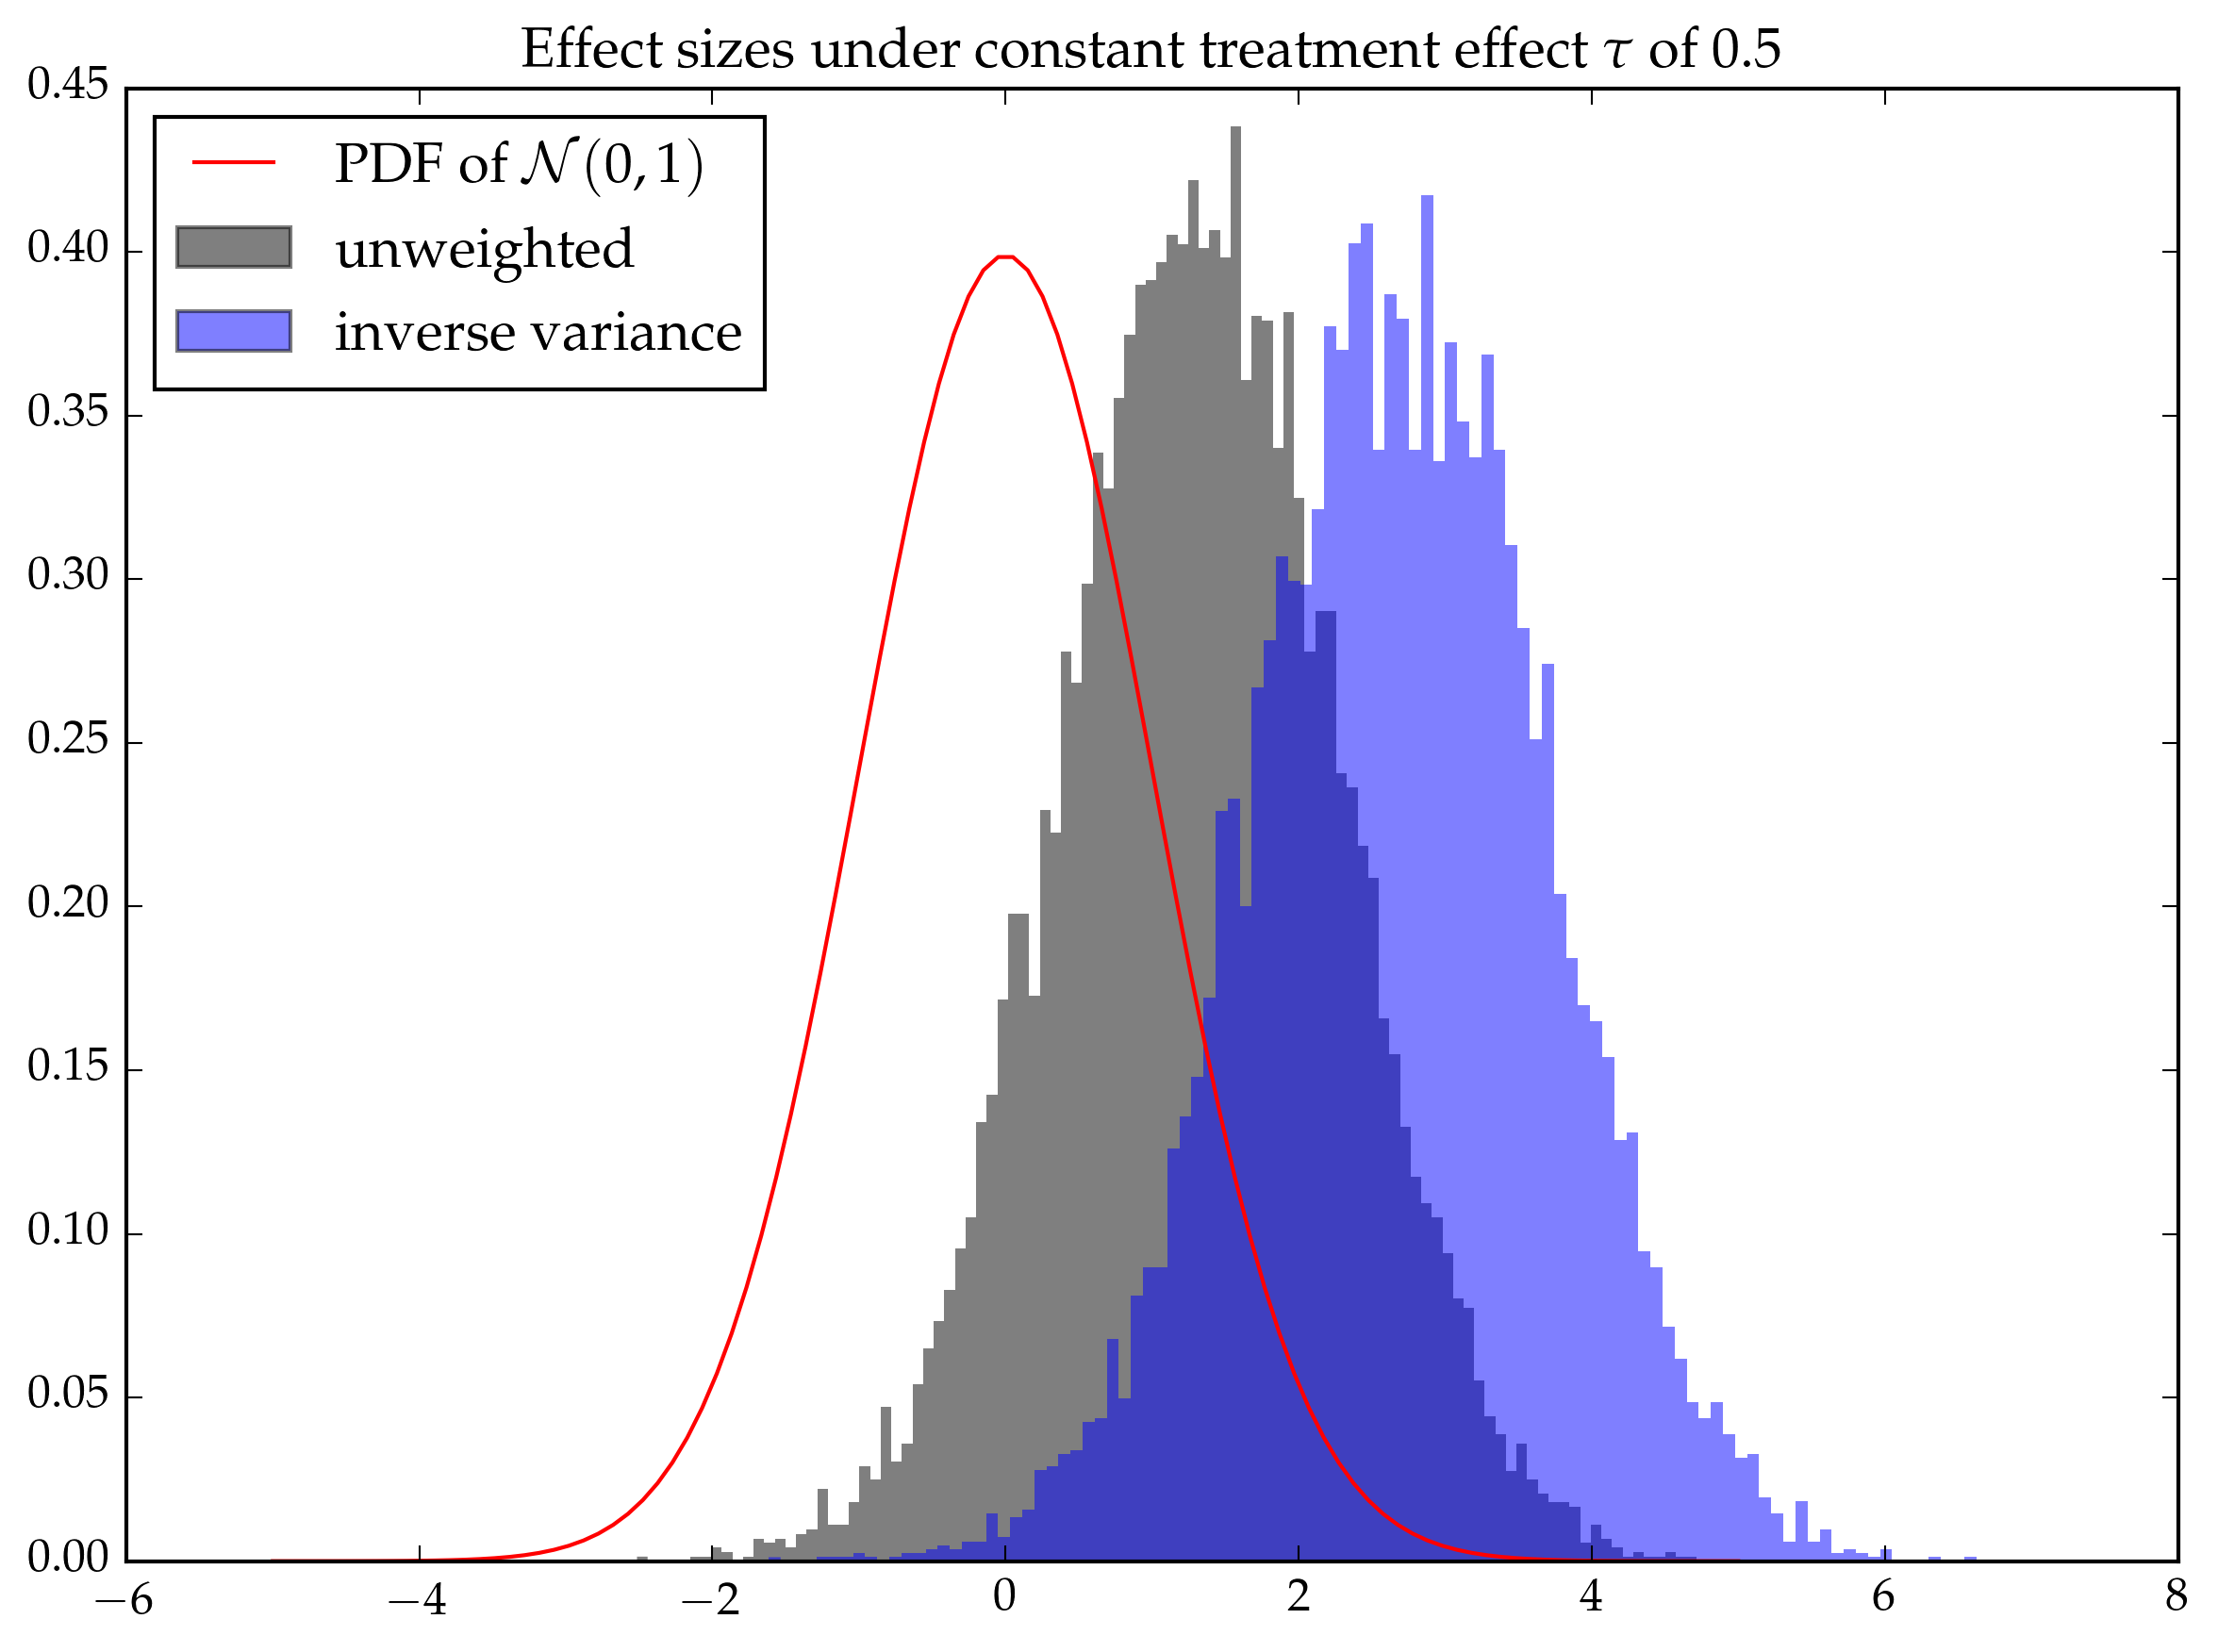

In [59]:
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_alt], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_alt], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title(L"Effect sizes under constant treatment effect $\tau$ of 0.5")
plt.legend(loc="upper left")
;

Not too bad! This seems to be doing something sensible. It seems pretty clear that the inverse-variance estimator will have higher power to detect a constant effect like this.

# Hypothesis testing (failed idea)

What if we want to test the hypothesis that $\tau(x)=0 ~ \forall x$? One idea is to evaluate the PDF of the posterior $\tau(x)$ at zero, and compare it to the distribution of the PDF under the posterior distribution. The problem is that $\Sigma^{post}$ is not necessarily numerically positive definite:

In [41]:
posteriorτx = MultivariateNormal(μposterior, Σposterior)

LoadError: LoadError: Base.LinAlg.PosDefException(10)
while loading In[41], in expression starting on line 1

That's because numerically, $\Sigma^{post}$ has some negative eigenvalues:

In [42]:
println(eigvals(Σposterior)[1:10])

[-0.10559243480016912,-0.10136054002883192,-0.04491534739041568,-0.044026391084063504,-0.02716623727288877,-0.026514793165469328,-0.017250902058669467,-0.01643157467590857,-0.011748107388190298,-0.011561966676011356]


Hacky solution: add enough weight on the diagonal of $\Sigma^{post}$ so the eigenvalues are positive.

In [43]:
Σposdef = Σposterior .+ (0.1+abs(min(minimum(eigvals(Σposterior)),0.0))).*eye(n◫)
println(eigvals(Σposdef)[1:10])

[0.09999999999999973,0.10423189477133678,0.160677087409754,0.16156604371610608,0.17842619752727984,0.17907764163469891,0.18834153274149984,0.1891608601242607,0.19384432741197938,0.19403046812415792]


In [44]:
posteriorτx = MultivariateNormal(μposterior, Σposdef)
pdf0 = logpdf(posteriorτx, zeros(Float64, n◫))
pdfμ = logpdf(posteriorτx, μposterior)
pdfsamples = Float64[logpdf(posteriorτx, rand(posteriorτx)) for _ in 1:10000]
;

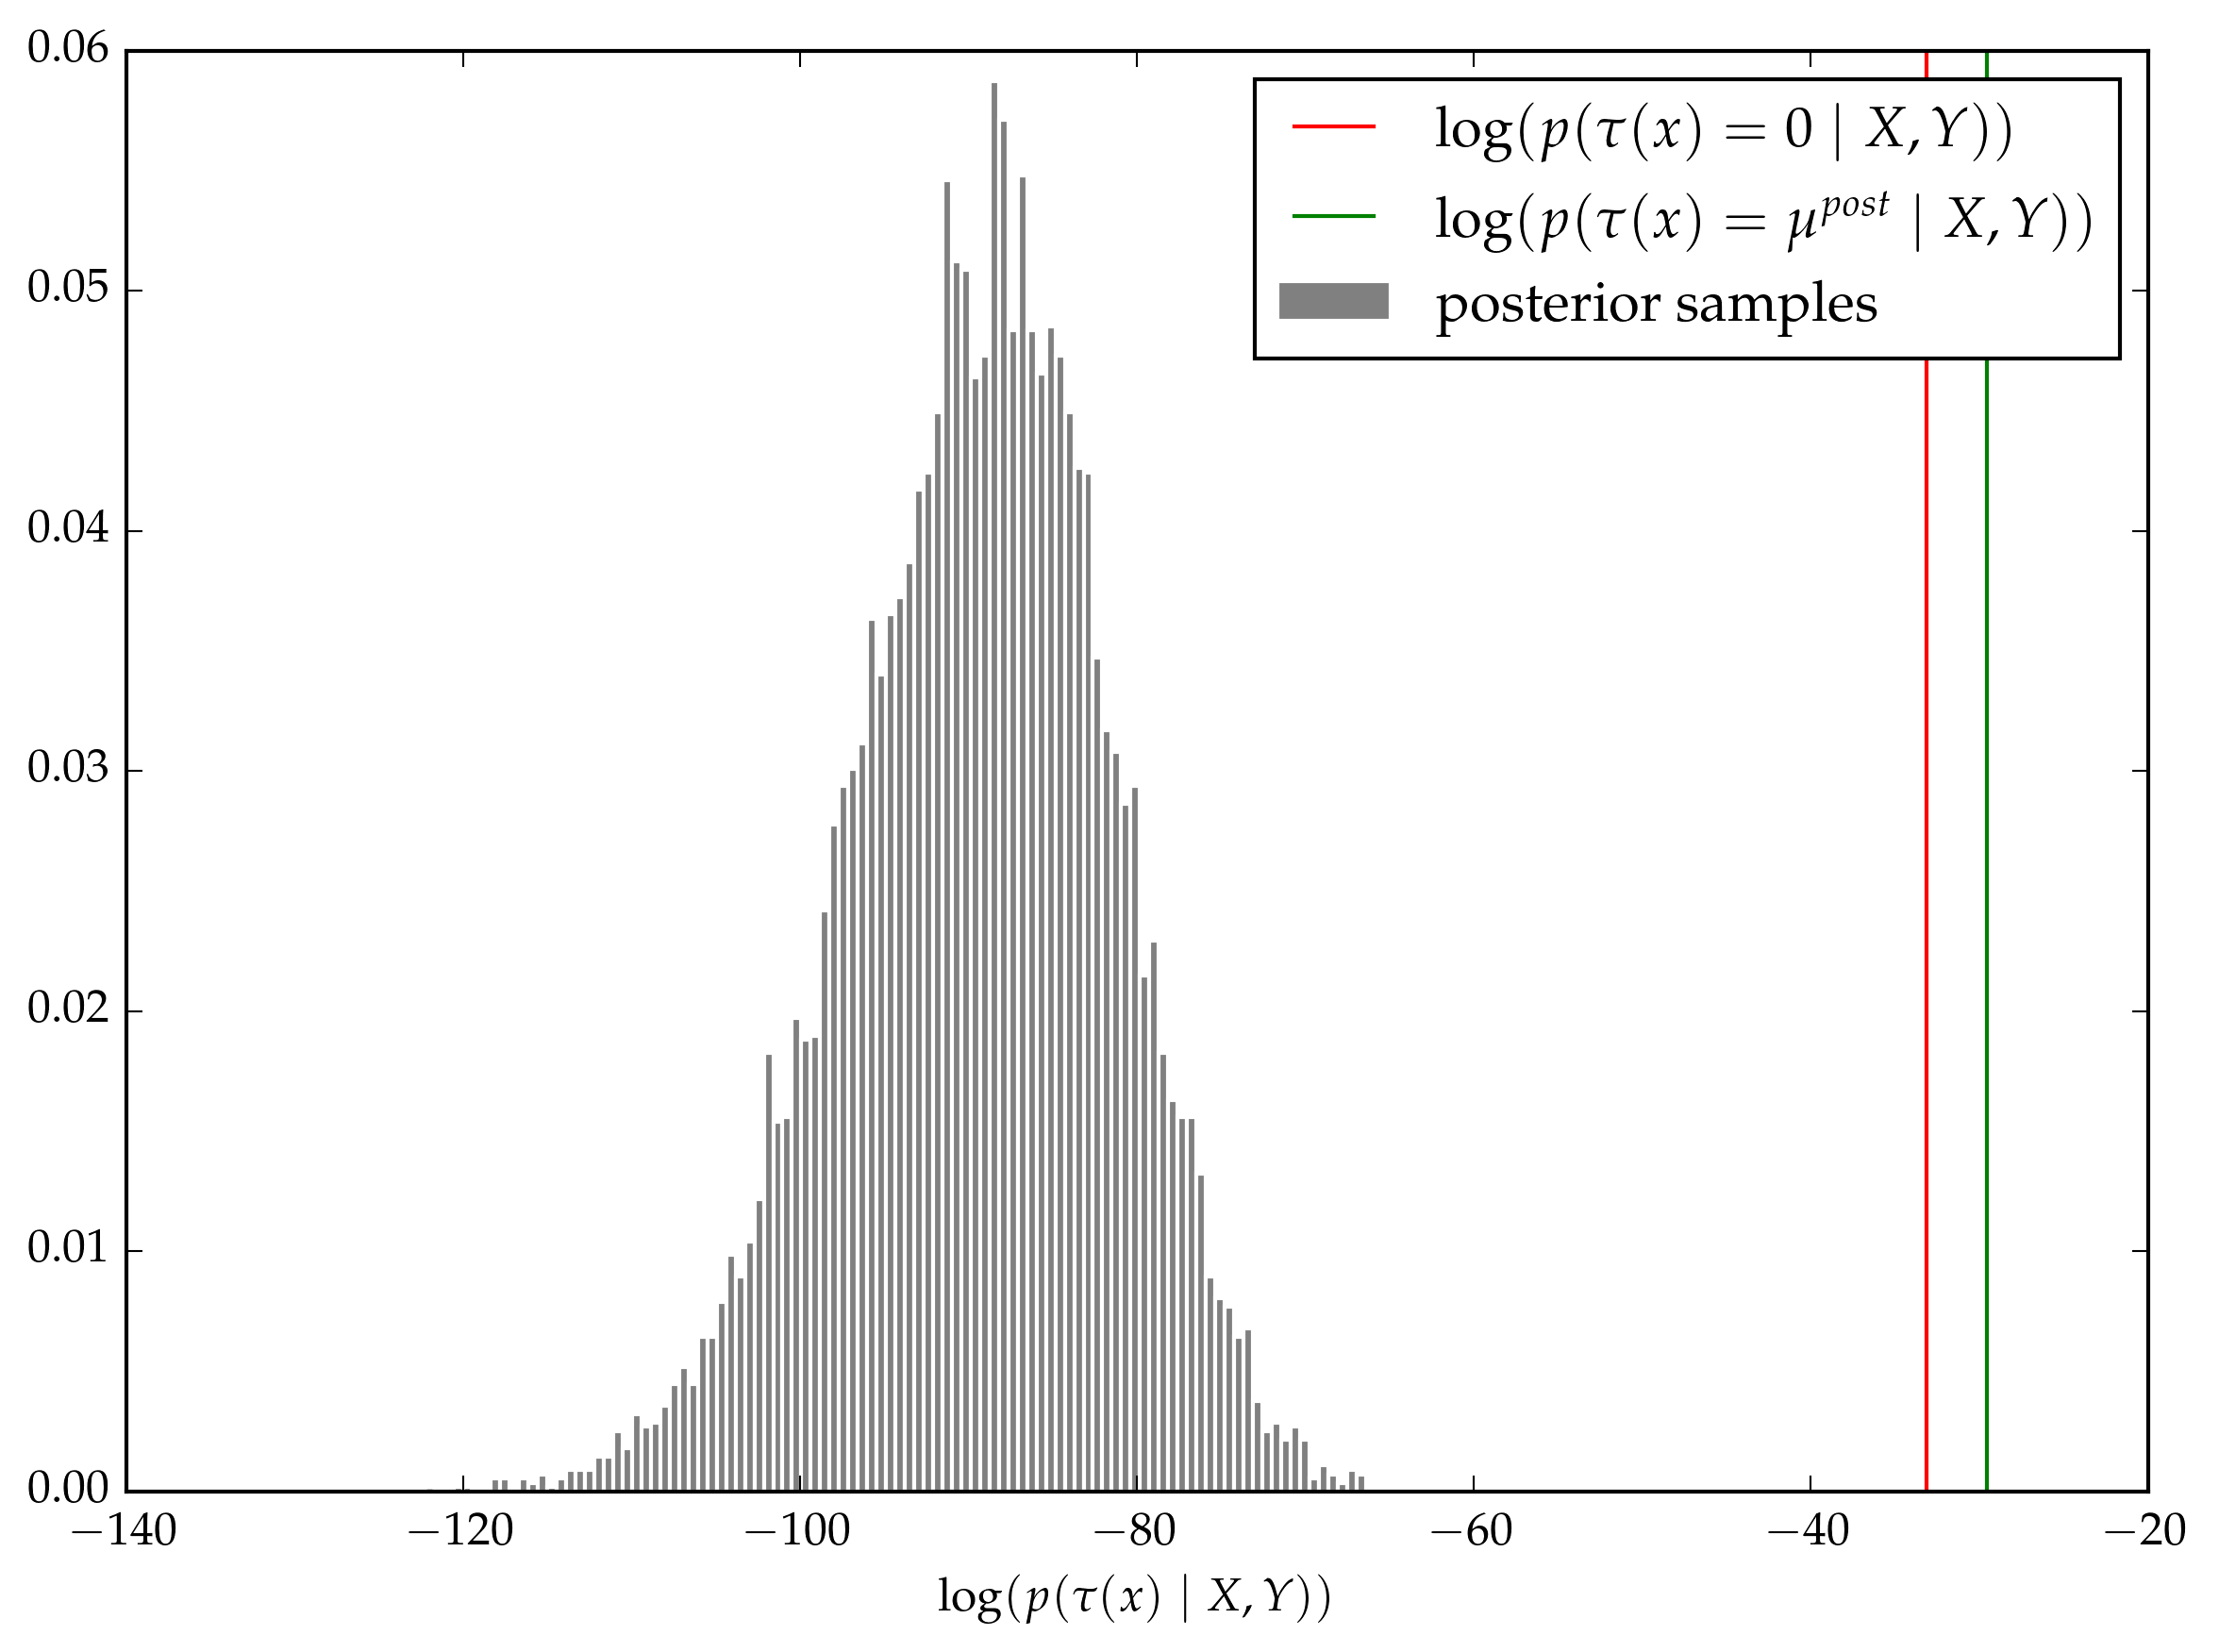

In [45]:
plt.plt[:interactive](true)
plt.axvline(pdf0, color="red", label=L"\log(p(\tau(x)=0 \mid X,Y))")
plt.plt[:interactive](false)
plt.axvline(pdfμ, color="green", label=L"\log(p(\tau(x)=\mu^{post} \mid X,Y))")
plt.plt[:hist](pdfsamples, bins=100, normed=true, color="grey", edgecolor="white", label="posterior samples")
plt.legend(loc="best")
# plt.xlim(-0.1,pdf0+0.1)
plt.xlabel(L"\log(p(\tau(x) \mid X,Y))")
plt.plt[:interactive](true)

**Conclusion:** this doesn't work at all because of the curse of dimensionality. All posterior samples have much *lower* likelihood than $\vec{0}$.

# Hypothesis test using $\chi^2$ test

Alessio Benavoli and Francesca Mangili have a paper on “Gaussian Processes for Bayesian hypothesis tests on regression functions”. It's not a very good paper, but one of their $\chi^2$ tests looks like it could be applicable here. From section 3, “equality tests”, we should follow the following procedure. First, following their equation 11, compute
$$ \mu^\intercal \Sigma^{-1} \mu $$
and compare it to $\chi^2_\nu(1-\alpha)$ where $\nu$ is the number of positive eigenvalues of $\Sigma$. Because of the numerical instability of the eigenvalues, this is ill-defined, and they recommend counting eigenvalues that satisfy
$$\lambda_{i} \big/ \sum_{i=1}^n \lambda_i < \epsilon$$ and they use $\epsilon=0.01$. We also replace $\Sigma$ with all low eigenvalues zeroed-out.

In [24]:
function get_pval(μ::Vector{Float64}, Σ::Matrix{Float64}, ϵ::Float64)    
    Σsvd = svdfact(Σ)
    λvec = Σsvd[:S] # sorted in decreasing order
    aboveϵ = (λvec ./ sum(λvec)) .> ϵ
    ν = max(sum(aboveϵ),1)
    Sabove = Σsvd[:S][aboveϵ]
    Σsvd[:S][:] = 1./Σsvd[:S] # invert high eigenvalues
    Σsvd[:S][!aboveϵ] = 0.0 # but remove low eigenvalues
    t = dot(μ, (full(Σsvd) * μ))
    nullhypo = Chisq(ν)
    pval = ccdf(nullhypo, t)
    return pval
end

get_pval (generic function with 1 method)

The obvious problem is that the estimated $\nu$ is very sensitive to the choice of $\epsilon$. Does this affect the p-values? Let's check.

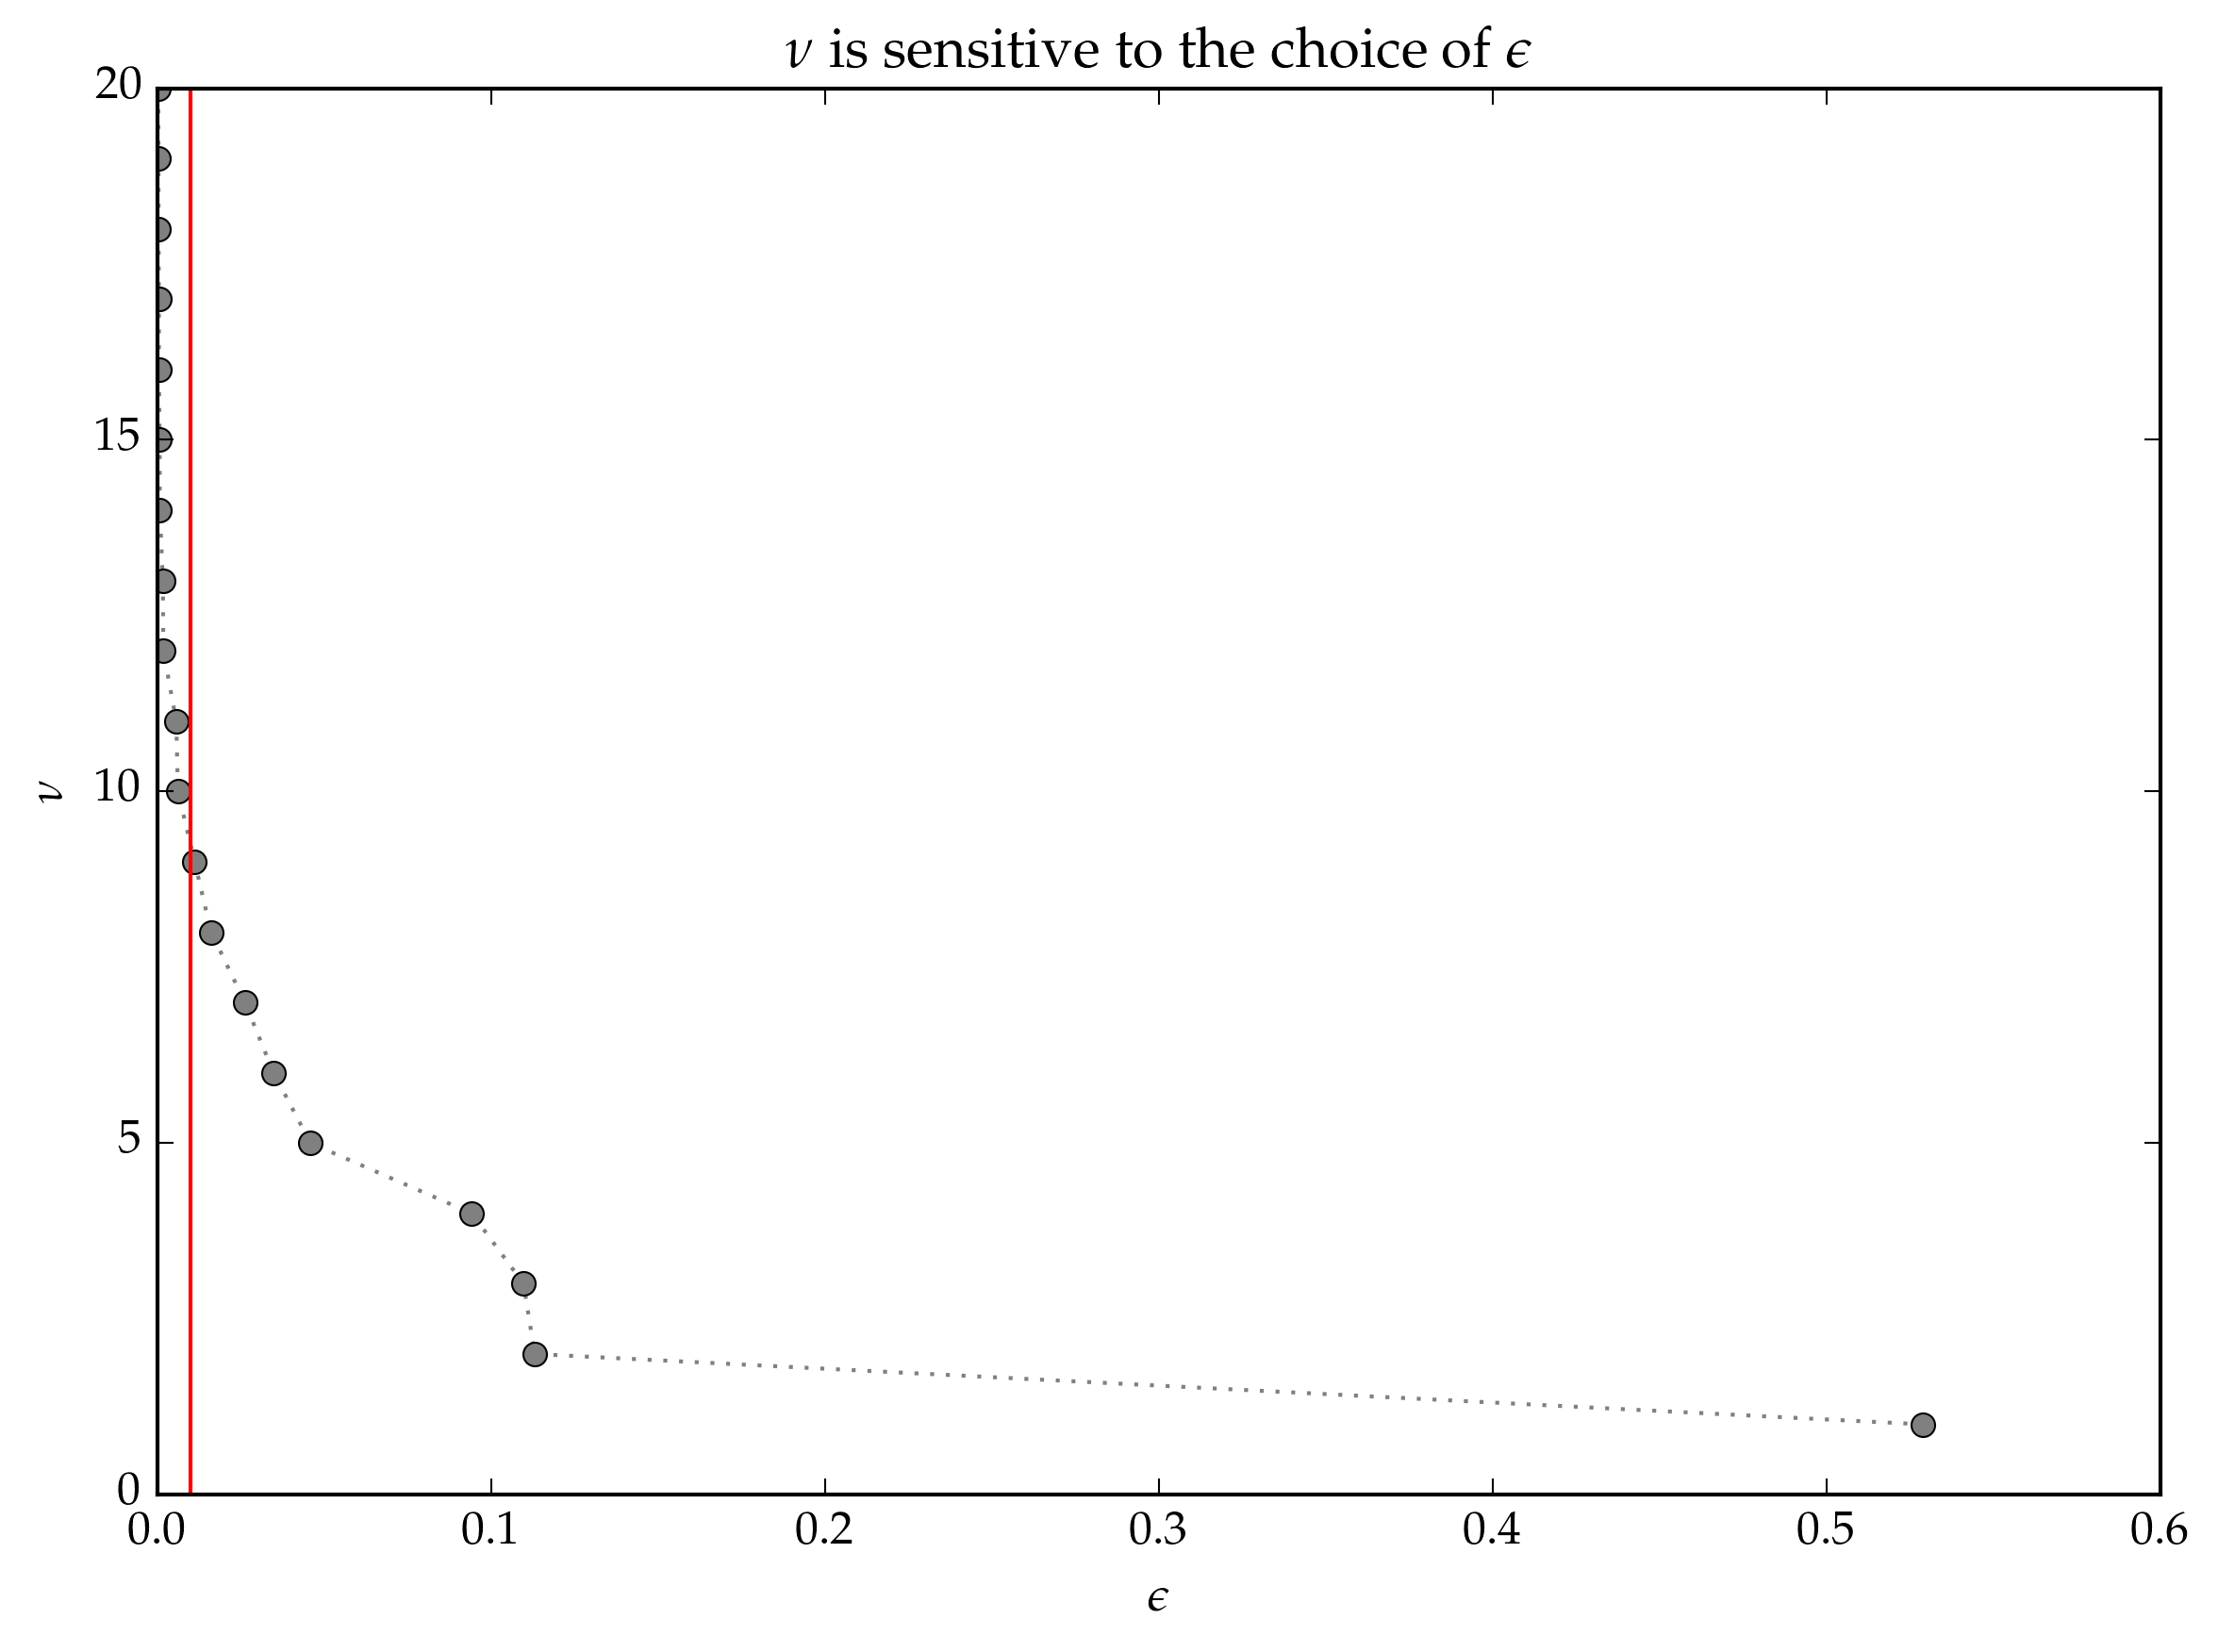

In [46]:
λvec = eigvals(Σposterior)
λpos = λvec[λvec .> 0]
plt.plot(reverse(λpos ./ sum(λpos)), 1:length(λpos), ":o", color="grey")
plt.axvline(0.01, color="red")
plt.title(L"$\nu$ is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel(L"\nu")
plt.ylim(0,20)
;

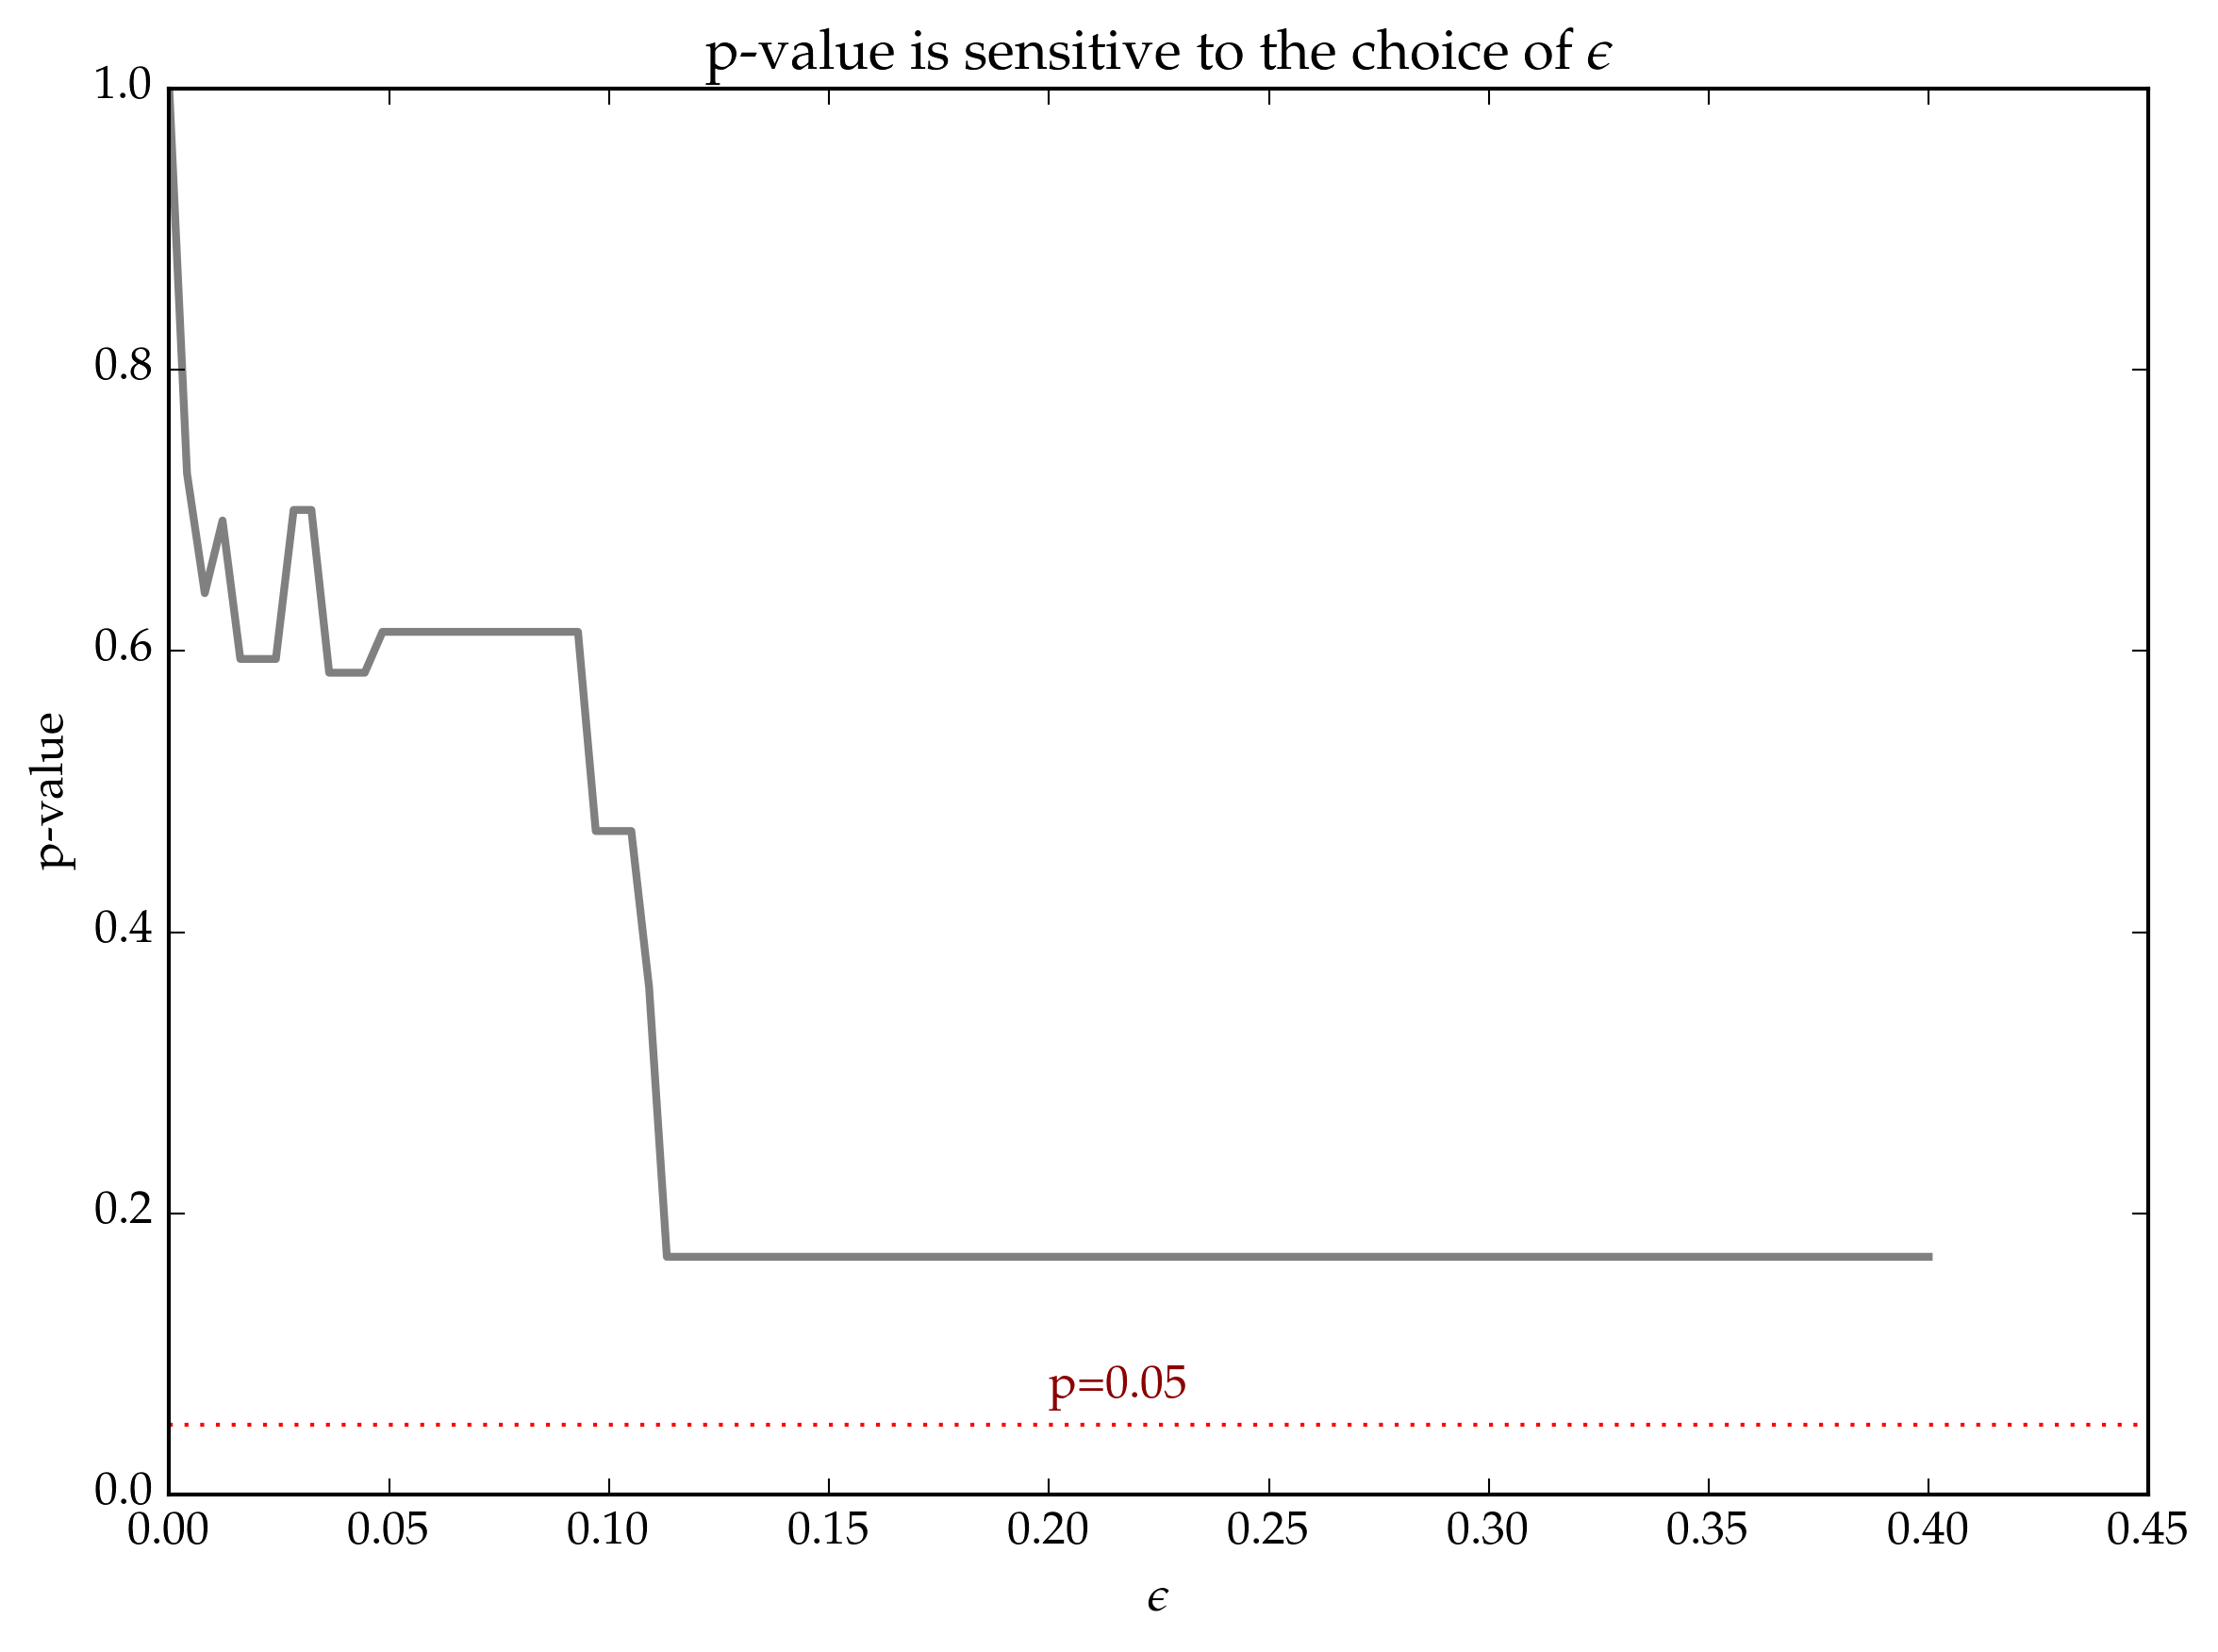

In [47]:
xϵ = linspace(0,0.4,100)
plt.plot(xϵ, [get_pval(μposterior, Σposterior, ϵ) for ϵ in xϵ], "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=0.2, y=0.06, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

The fact that the p-value is quite sensitive to $\epsilon$ is a real issue. It's not always monotonic either. The derivative is particularly steep when $\epsilon$ is low, near the suggested $\epsilon=0.01$.

## p-values under the null

We'll carry on with $\epsilon=0.01$, and simulate under the null, still with locations fixed so we can re-use the Cholesky decomposition of the covariance matrix, which speeds up our simulations.

In [27]:
function sim_pval_null(ϵ::Float64)
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    return get_pval(μpost, Σpost, ϵ)
end

sim_pval_null (generic function with 1 method)

In [28]:
pvalues_null = Float64[sim_pval_null(0.01) for _ in 1:10000];

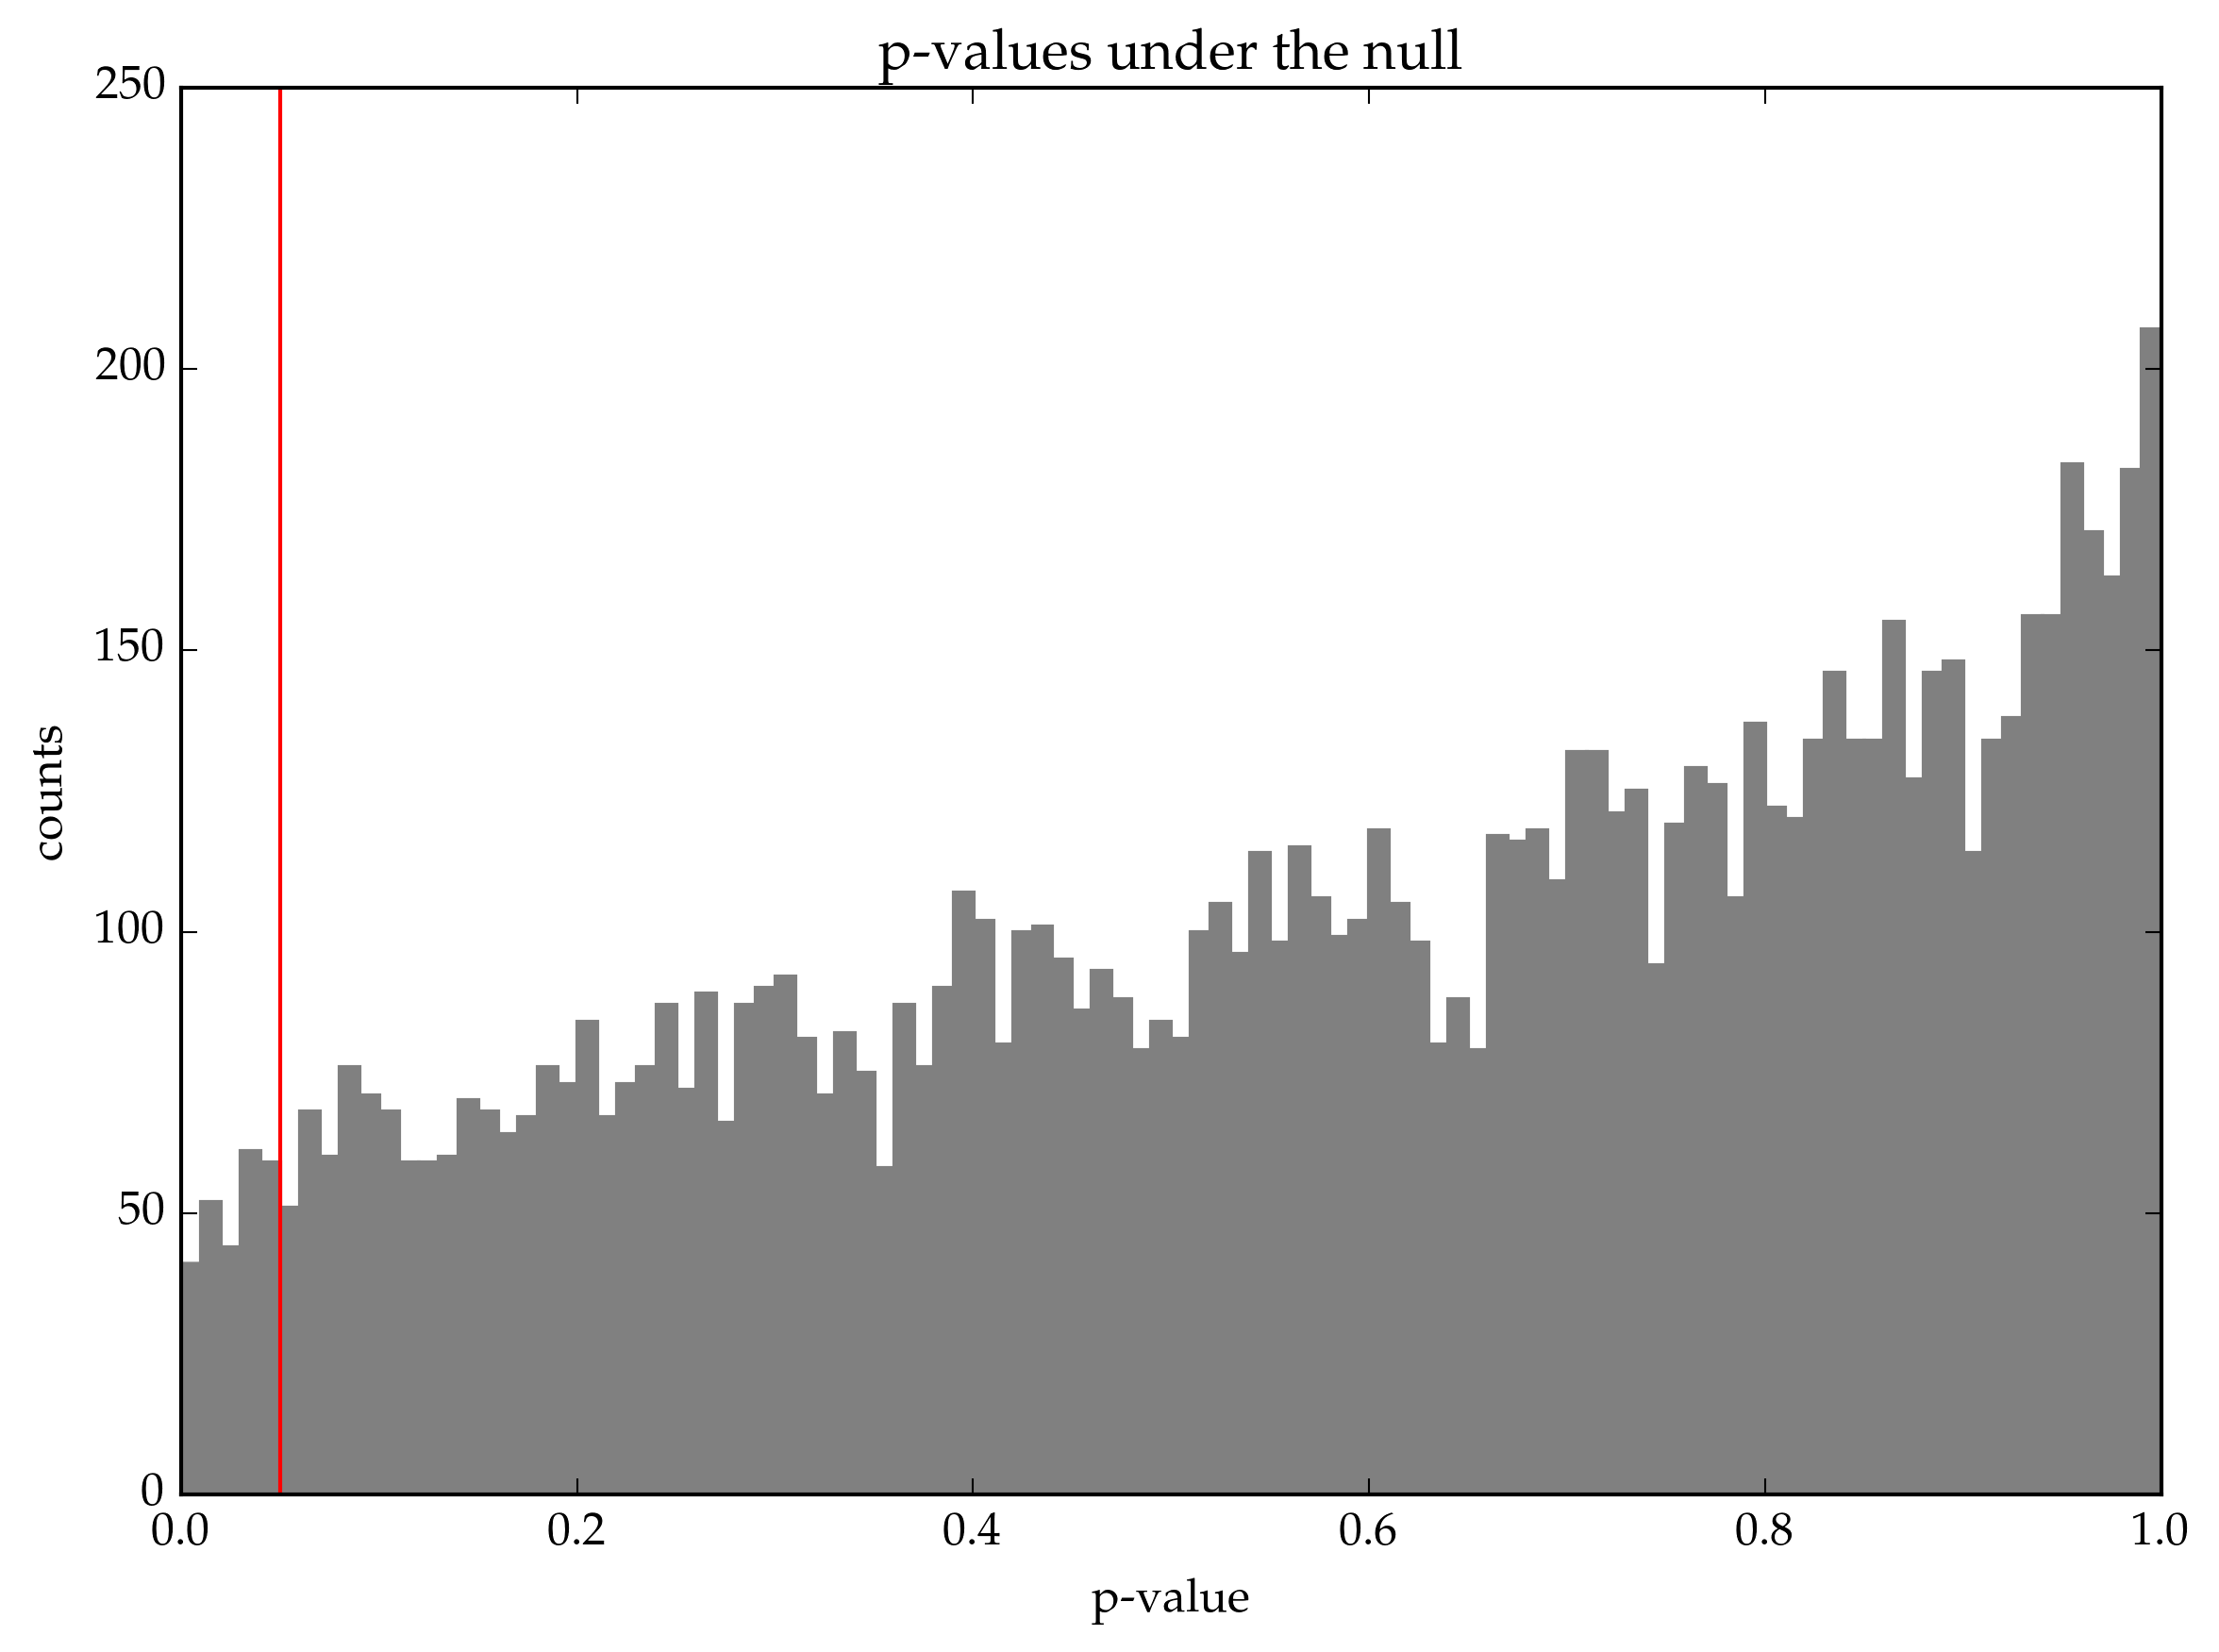

In [29]:
plt.plt[:interactive](true)
plt.axvline(0.05, color="red")
plt.plt[:interactive](false)
plt.plt[:hist](pvalues_null, bins=100, color="grey", edgecolor="grey")
plt.xlabel("p-value")
plt.ylabel("counts")
plt.title("p-values under the null")
;

The p-values aren't quite uniform. It looks like this test might be slightly conservative. Interesting...

## p-values under alternative

In [30]:
function sim_pval_alt(τ::Float64, ϵ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    return get_pval(μpost, Σpost, ϵ)
end

sim_pval_alt (generic function with 1 method)

In [31]:
pvalues_alt = Float64[sim_pval_alt(1.0, 0.01) for _ in 1:1000];

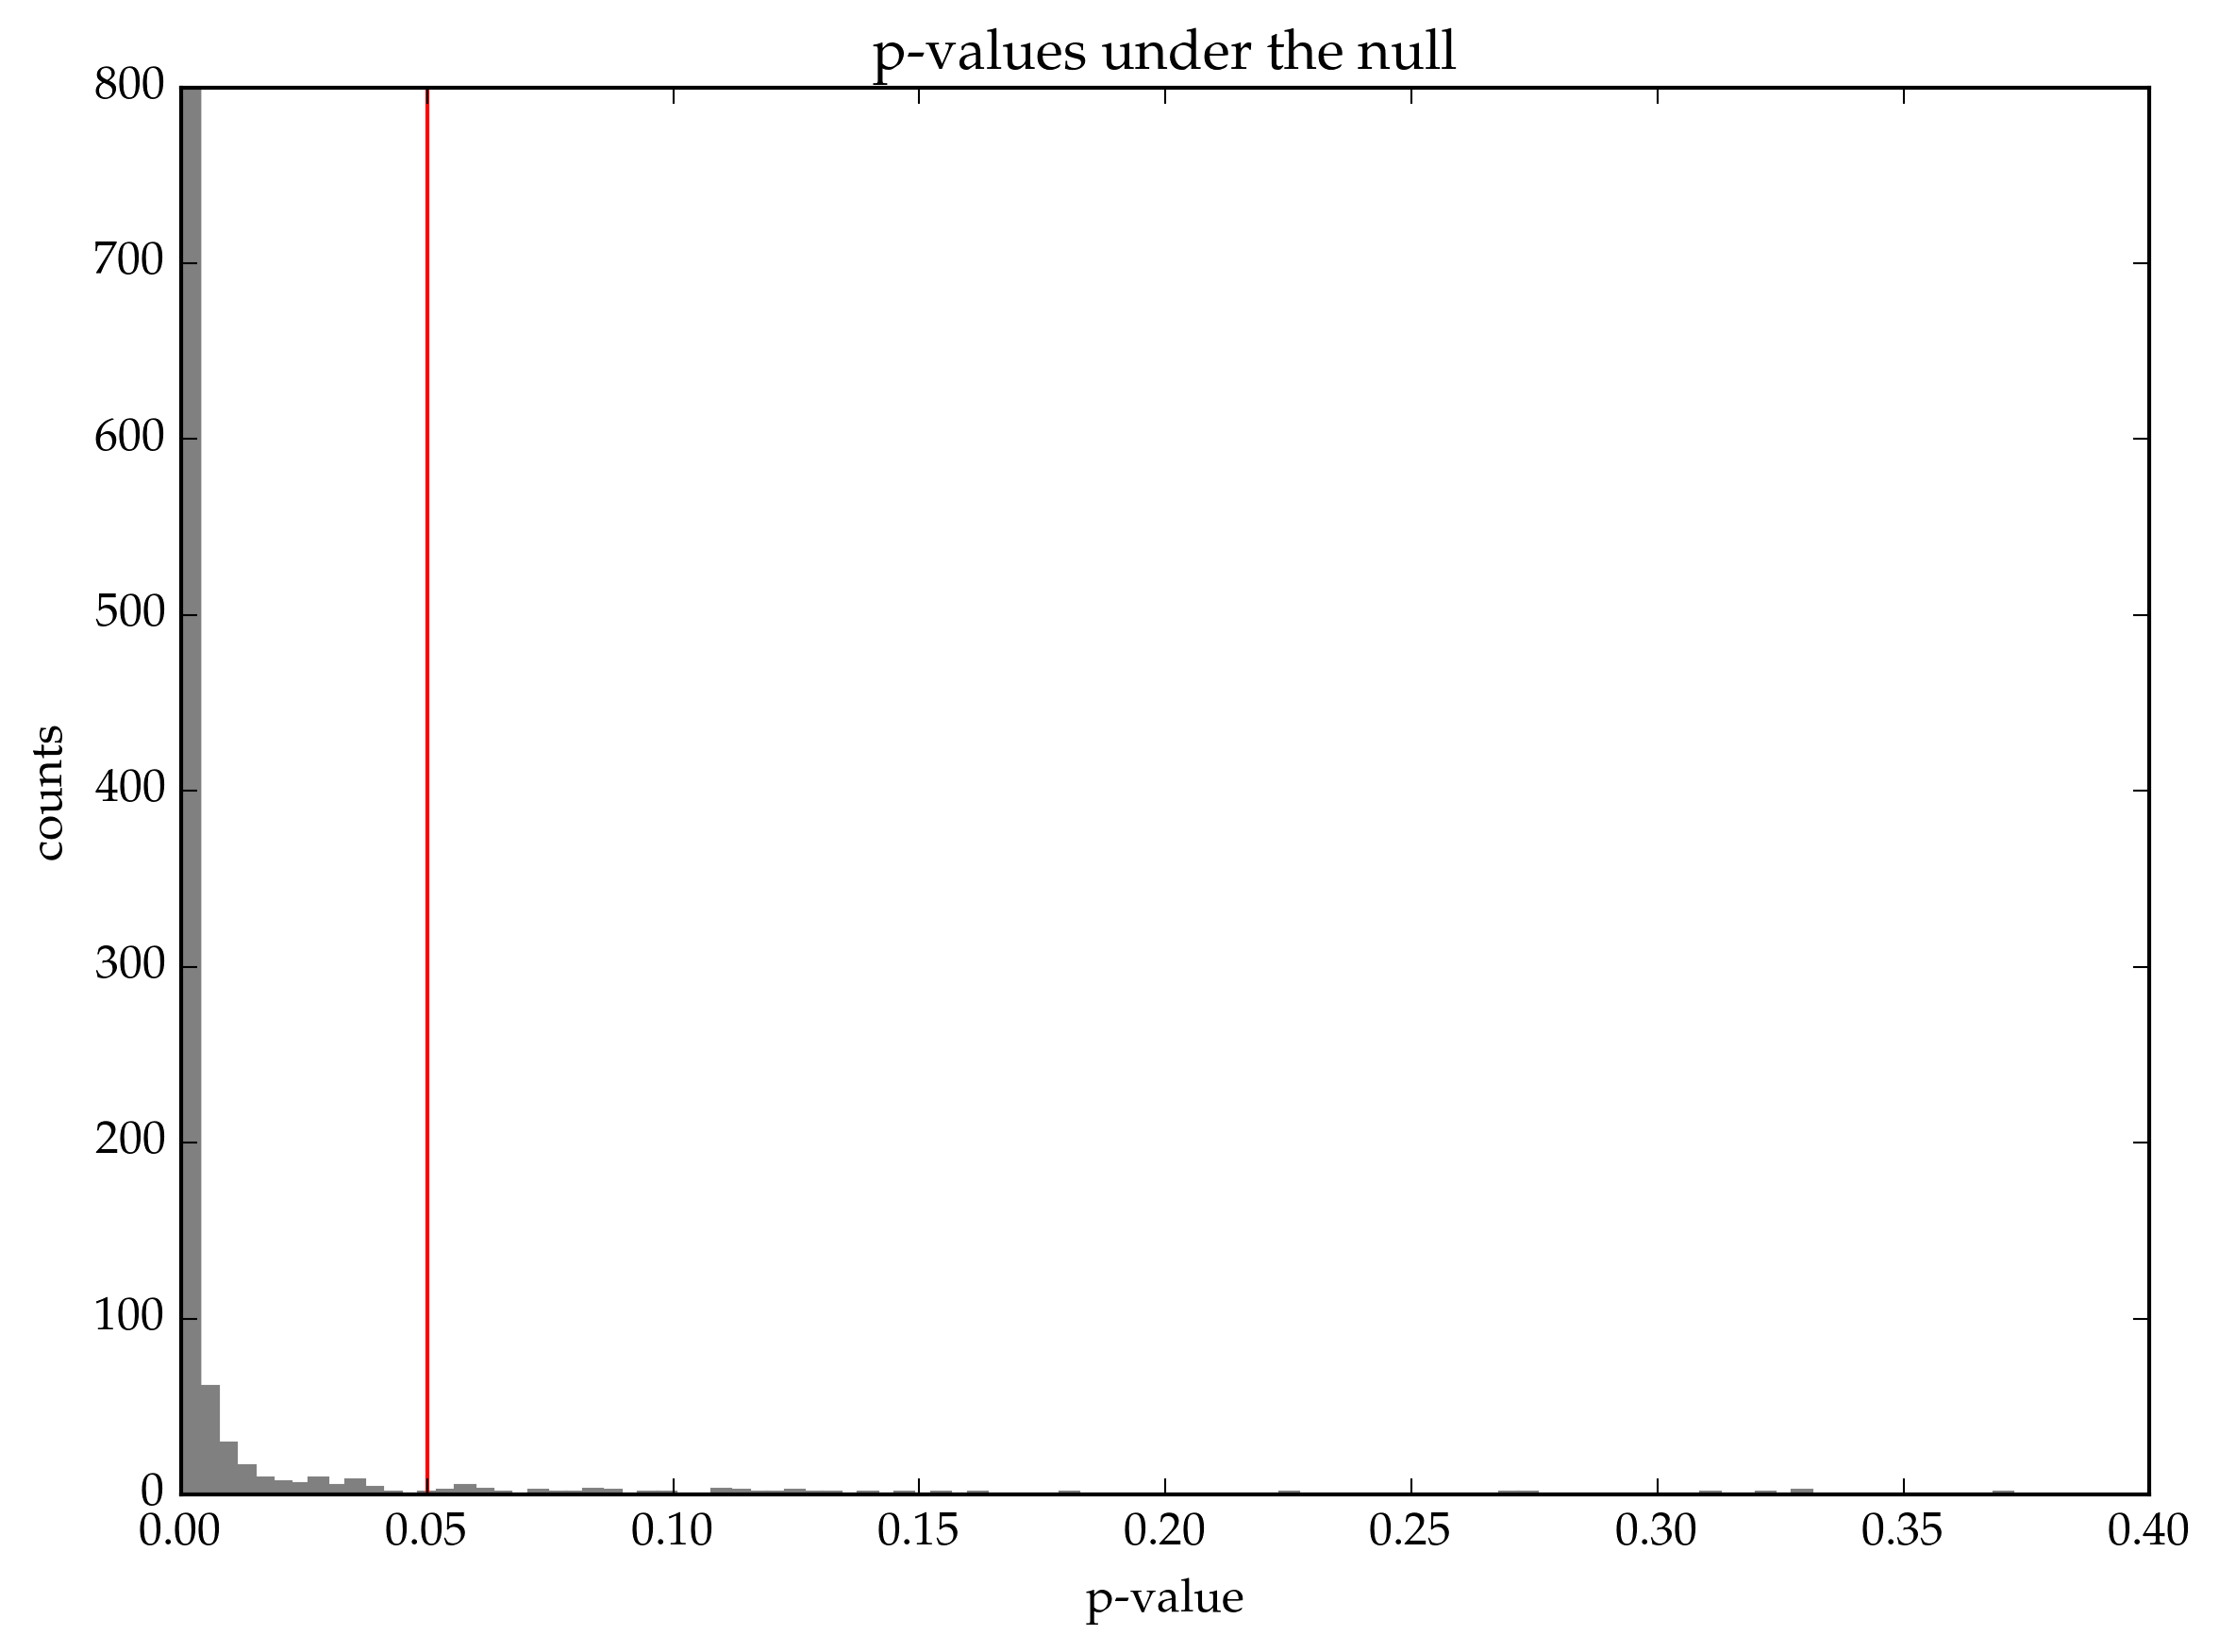

In [32]:
plt.plt[:interactive](true)
plt.axvline(0.05, color="red")
plt.plt[:interactive](false)
plt.plt[:hist](pvalues_alt, bins=100, color="grey", edgecolor="grey")
plt.xlabel("p-value")
plt.ylabel("counts")
plt.title("p-values under the null")
;

In [33]:
mean(pvalues_alt.<0.05) # power

0.953

Cool!